# Declustering 

In [1]:
import os
userdir = os.environ['USERPROFILE']
onedrive_folder = os.environ['ONEDRIVE']

github_dir = os.path.join(userdir,'Documents','GitHub','initial_group_codes') # Set filepath to WSP GitHub repository
oq_dir = os.path.join(userdir, 'Documents', 'GitHub', 'oq-engine') # Set filepath to OpenQuake Engine GitHub repository


import sys
if github_dir not in sys.path:
    sys.path.insert(0,github_dir)
if oq_dir not in sys.path:
    sys.path.insert(0,oq_dir)
import pandas as pd
import numpy as np
import shapely
from datetime import datetime
import glob
from pprint import pprint


#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

from openquake.hmtk.parsers.catalogue import CsvCatalogueParser
#plotting
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_depth_histogram, plot_magnitude_depth_density, plot_magnitude_time_density
from openquake.hmtk.plotting.seismicity.occurrence.recurrence_plot import plot_recurrence_model,plot_trunc_gr_model

#declustering
from openquake.hmtk.seismicity.declusterer.distance_time_windows import UhrhammerWindow
from openquake.hmtk.seismicity.declusterer.dec_gardner_knopoff import GardnerKnopoffType1
#completeness
from openquake.hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971
from openquake.hmtk.plotting.seismicity.completeness.plot_stepp_1972 import create_stepp_plot
#sub-set catalogue
from openquake.hmtk.seismicity.selector import CatalogueSelector
from openquake.hazardlib.geo.polygon import Polygon
from openquake.hazardlib.geo.point import Point
#calculate recurrence params
from openquake.hmtk.seismicity.occurrence.weichert import Weichert
from openquake.hmtk.seismicity.occurrence.utils import get_completeness_counts, recurrence_table
#magnitude-frequency distributions
from openquake.hazardlib.mfd.truncated_gr import TruncatedGRMFD
from openquake.hazardlib.mfd.evenly_discretized import EvenlyDiscretizedMFD
#smoothing for gridded source
from openquake.hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity, Grid
from openquake.hmtk.seismicity.smoothing.kernels.isotropic_gaussian import IsotropicGaussian
#sources
from openquake.hmtk.sources.complex_fault_source import mtkComplexFaultSource
#geometry
from openquake.hazardlib.geo.surface.complex_fault import ComplexFaultSurface
from openquake.hazardlib.geo.mesh import RectangularMesh
from openquake.hazardlib.geo import Line, Point



print(sys.path)
print(sys.path)

['C:\\Users\\CANC079442\\Documents\\GitHub\\oq-engine', 'C:\\Users\\CANC079442\\Documents\\GitHub\\initial_group_codes', 'C:\\Users\\CANC079442\\WSP O365\\NZ Project - WSP Chile_Las Tortolas and Perez Caldera (6-DY091.00) - PSHA\\seismicity_catalogue_NC_v2', 'C:\\Users\\CANC079442\\AppData\\Local\\miniforge3\\envs\\psha2\\python311.zip', 'C:\\Users\\CANC079442\\AppData\\Local\\miniforge3\\envs\\psha2\\DLLs', 'C:\\Users\\CANC079442\\AppData\\Local\\miniforge3\\envs\\psha2\\Lib', 'C:\\Users\\CANC079442\\AppData\\Local\\miniforge3\\envs\\psha2', '', 'C:\\Users\\CANC079442\\AppData\\Local\\miniforge3\\envs\\psha2\\Lib\\site-packages', 'C:\\Users\\CANC079442\\AppData\\Local\\miniforge3\\envs\\psha2\\Lib\\site-packages\\win32', 'C:\\Users\\CANC079442\\AppData\\Local\\miniforge3\\envs\\psha2\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\CANC079442\\AppData\\Local\\miniforge3\\envs\\psha2\\Lib\\site-packages\\Pythonwin']
['C:\\Users\\CANC079442\\Documents\\GitHub\\oq-engine', 'C:\\Users\\CANC0

In [2]:
# Import WSP GitHub functions
from PSHA.General.SeisCat.seismic_catalogue_tools import *
from MISC.map_tools import plot_basemap

In [3]:
topdir = os.path.join(userdir,'WSP O365','NZ Project - WSP Chile_Las Tortolas and Perez Caldera (6-DY091.00) - PSHA','seismicity_catalogue_NC_v2')

cut_dir = os.path.join(topdir,'cut_catalogue')
if not os.path.exists(cut_dir):
    os.mkdir(cut_dir)
decluster_dir = os.path.join(topdir,'declustered_catalogue')
if not os.path.exists(decluster_dir):
    os.mkdir(decluster_dir)
source_model_dir = os.path.join(os.path.dirname(topdir),'source_model_files')
if not os.path.exists(source_model_dir):
    os.mkdir(source_model_dir)

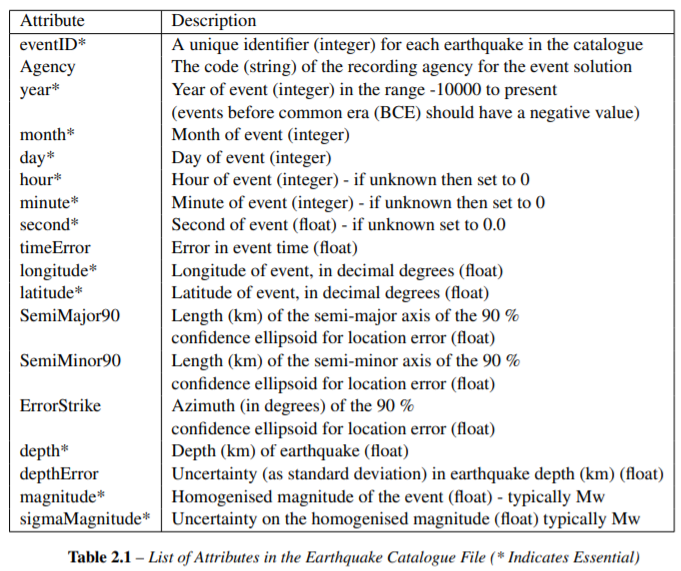

# Read in final cut catalogues into OpenQuake Catalogue format

In [ ]:
full_catalogue_oldfmt = pd.read_csv(os.path.join(topdir,'full_catalogue','LT_UpdatedFullCat_DupPurged_v2.csv'))

catalogues_oldfmt = [full_catalogue_oldfmt]

In [ ]:
OQ_catalogues = dict.fromkeys(['full'])

for cat_type,old_cat in zip(OQ_catalogues.keys(),catalogues_oldfmt):
    OQ_catalogues[cat_type] = old_cat_format_to_OQ(old_cat)
    OQ_catalogues[cat_type] = OQ_catalogues[cat_type].astype({'year':int,'month':int,'day':int,'hour':int,'minute':int})
    OQ_catalogues[cat_type].to_csv(os.path.join(topdir,'full_catalogue',cat_type+'_catalogueOQ.csv'),index=False)

In [ ]:
display(OQ_catalogues['full'].head())

In [ ]:
full_catalogue_filename = os.path.join(topdir,'full_catalogue','full_catalogueOQ.csv')
parser = CsvCatalogueParser(full_catalogue_filename)
full_catalogue = parser.read_file()

In [ ]:
# # You can read in the declustered OQ-format catalogue once you have produced it using the code further down this notebook
# decl_catalogue_filename = os.path.join(topdir,'declustered_catalogue','full_declusteredOQ.csv')
# parser = CsvCatalogueParser(decl_catalogue_filename)
# decl_catalogue = parser.read_file()

In [ ]:
print('full catalogue events =',full_catalogue.get_number_events())

# Choose catalogue to analyse

In [ ]:
cat_type = 'full'
catalogue = full_catalogue
# cat_type = 'decl'
# catalogue = decl_catalogue

m_min = 3.0

In [ ]:
catalogue = CatalogueSelector(catalogue, create_copy=True).within_magnitude_range(lower_mag=m_min, upper_mag=None)
print(catalogue)

# Decluster with GardnerKnopoff74

In [ ]:
#if not os.path.exists(os.path.join(decluster_dir,cat_type+'_declusteredOQ.csv')): 
print(catalogue)
print('Events before declustering: ',catalogue.get_number_events())
declustering = GardnerKnopoffType1()

#Use Uhrhammer 1986 time-distance windows
declust_config = {'time_distance_window': UhrhammerWindow(), 
                  'fs_time_prop': 1.0}

cluster_index,cluster_flag = declustering.decluster(catalogue, 
                                                     declust_config)

## To add clustering information to catalogue
 cluster_index : indicates cluster to which event belongs to (0 = no cluster)  
 cluster_flag : 0 = mainshock, 1 = foreshock/aftershock

In [ ]:
# To add clustering information to catalogue
# cluster_index : indicates cluster to which event belongs to (0 = no cluster) 
# cluster_flag : 0 = mainshock, 1 = foreshock/aftershock

#if not os.path.exists(os.path.join(decluster_dir,cat_type+'_declusteredOQ.csv')):

catalogue.data['Cluster_Index'] = cluster_index
catalogue.data['Cluster_Flag'] = cluster_flag


## Remove clustered events

In [ ]:
#if not os.path.exists(os.path.join(decluster_dir,cat_type+'_declusteredOQ.csv')):
mainshock_flag = cluster_flag == 0
catalogue.purge_catalogue(mainshock_flag)
print('Events after declustering: ',catalogue.get_number_events())

# Write declustered catalogues to files

In [ ]:
catalogue.write_catalogue(os.path.join(decluster_dir,cat_type+'_declusteredOQ.csv'))

# Completeness

## Manually create completeness table

In [ ]:
completeness_table_a = np.array([[1985., 4.5],
                                 [1970., 5.0], 
                                 [1965., 5.5], 
                                 [1934., 6.0], 
                                 [1917., 6.5], 
                                 [1904., 7.0], 
                                 [1850., 7.5], 
                                 [1819., 8.0], 
                                 [1730., 8.5],])

## Completeness from Stepp 1971 for sub-catalogue

In [ ]:
full_catalogue_filename = os.path.join(topdir,'full_catalogue','full_catalogueOQ.csv')
parser = CsvCatalogueParser(full_catalogue_filename)
full_catalogue = parser.read_file()

In [ ]:
# Re-select full catalogue to use in completeness assessment
cat_type = 'full'
catalogue = full_catalogue

In [ ]:
completeness_algorithm = Stepp1971()

# increment_lock = True : the program will ensure that the completeness magnitude
# for shorter, more recent windows is less than or equal to that of older, longer windows
# increment_lock = False : Show the apparent variability 

comp_config = {'magnitude_bin': 0.5, 
               'time_bin': 5., #time window in years
               'increment_lock': True} # True: ensure time increases with completeness magnitude

completeness_table = completeness_algorithm.completeness(catalogue, 
                                                         comp_config)

print('Stepp1971 completeness')
print(completeness_table)

print('Our completeness')
print(completeness_table_a)

# plot it

create_stepp_plot(completeness_algorithm, 
                  figure_size=(8, 6), 
                  filename=os.path.join(topdir,'completeness',cat_type+'_stepp71_plot.png'), 
                  filetype='png', 
                  dpi=300, 
                  ax=None);

# Slope completeness

In [ ]:
full = pd.read_csv(os.path.join(topdir,'full_catalogue','full_catalogueOQ.csv'))
declustered = pd.read_csv(os.path.join(topdir,'declustered_catalogue','full_declusteredOQ.csv'))

cat_choice = 'full' # 'full' or 'declustered'

if cat_choice == 'declustered':
    cat_df = declustered
elif cat_choice == 'full':
    cat_df = full

cat_df_sorted_mag = cat_df.sort_values(by=['magnitude'], ascending=False)
display(cat_df_sorted_mag)

In [ ]:
mmin = [4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5]
# mmin = [8.0,8.5]


fig, axs = plt.subplots(len(mmin),sharex=True,figsize=[12,2*len(mmin)])

for idx,minmag in enumerate(mmin):
    print(idx)
    df=cat_df
    import datetime
    zerodate = datetime.datetime(1500,1,1) # MANUAL INPUT, date format = (year,month,day)
    base = datetime.datetime.today()
    delta = base - zerodate
    numdays = delta.days
    print(numdays) 

    date_list = [base - datetime.timedelta(days=x) for x in range(numdays+1)]
    date_list.reverse()
    date_list2 = date_list[1:]

    datelist=[]

    for i in range(len(df)):
        if cat_choice == 'full':
            date=datetime.datetime(int(df.iloc[i,1]), int(df.iloc[i,2]),int(df.iloc[i,3]))
        elif cat_choice == 'declustered':
            date=datetime.datetime(int(df.iloc[i,2]), int(df.iloc[i,3]),int(df.iloc[i,4]))
            
        #print(date)
        datelist.append(date)


    df['origin_time']=datelist


    # Filter catalogue by mag and distance

    maxmag = minmag+0.5
    df = df.loc[(df['magnitude']>=minmag) & (df['magnitude']<=maxmag)]


    # Loop over each day
    num_earthquakes = []
    for date1, date2 in list(zip(date_list, date_list2)):
        # Count events each day - filter to between the older date in date_list and the newer date in date_list2
        events = df.loc[(df['origin_time']>=date1) & (df['origin_time']<date2)]
        num_earthquakes.append(len(events))

    # Get cummulative number of earthquakes 
    cumulative_eq = np.cumsum(np.array(num_earthquakes))

    # df = df[(df.magnitude>7)]

    x = np.where(completeness_table_a == minmag)
    yr_mag = completeness_table_a[x[0][0]]
    yr_comp = int(yr_mag[0])

    # Plot
    # fig, ax = plt.subplots(figsize=[10,2])
    plt.rc('font', size = 14)
    axs[idx].plot(date_list[:-1], cumulative_eq, label='Mw '+str(minmag)+' - '+str(maxmag),color='k')
    axs[idx].axvline(x=datetime.datetime(yr_comp,1,1), color='g')

    axs[idx].minorticks_on()
    axs[idx].set_xlim(datetime.datetime(1700,1,1),datetime.datetime(2023,11,17)) # Adjusted to automate the ylim to add 10% of the max no. EQs
    axs[idx].legend(loc='upper left',fontsize=10)

    axs[idx].grid(which='both')

fig.supxlabel('Year',fontsize=14)
fig.supylabel('Cumulative Earthquakes',fontsize=10)
fig.tight_layout()

fig.savefig(os.path.join(topdir,'completeness','slope_method',cat_choice+'.png'), format='PNG', dpi=300, bbox_inches='tight')

# Recombine catalogues to compute completeness (skip for now)

In [ ]:
# OQ_catalogues_declustered = dict.fromkeys(['crustal','interface','slab'])
# for this_cat_type in OQ_catalogues_declustered.keys():
#     parser = CsvCatalogueParser(os.path.join(decluster_dir,this_cat_type+'_declusteredOQ.csv'))
#     OQ_catalogues_declustered[this_cat_type] = parser.read_file()
#     print(OQ_catalogues_declustered[this_cat_type].get_number_events())

In [ ]:
# full_declustered_catalogue = OQ_catalogues_declustered['crustal']
# full_declustered_catalogue.concatenate(OQ_catalogues_declustered['interface'])
# full_declustered_catalogue.concatenate(OQ_catalogues_declustered['slab'])
# print(full_declustered_catalogue.get_number_events())
# full_declustered_catalogue.write_catalogue(os.path.join(decluster_dir,'declustered_cat.csv'))

In [ ]:
# completeness_algorithm = Stepp1971()

# # increment_lock = True : the program will ensure that the completeness magnitude
# # for shorter, more recent windows is less than or equal to that of older, longer windows
# # increment_lock = False : Show the apparent variability 

# comp_config = {'magnitude_bin': 0.5, 
#                'time_bin': 5., #time window in years
#                'increment_lock': True} # True: ensure time increases with completeness magnitude

# completeness_table_full = completeness_algorithm.completeness(full_declustered_catalogue, 
#                                                               comp_config)

# print(completeness_table_full)


# create_stepp_plot(completeness_algorithm, 
#                   figure_size=(8, 6), 
#                   #filename=os.path.join(topdir,'catalogue_analysis_figures','full_catalogue_stepp71_plot.png'), 
#                   #filetype='png', 
#                   dpi=300, 
#                   ax=None);

# Revise completeness table as appropriate (based on Stepp and slope plots above)

In [ ]:
completeness_table_a = np.array([[1985., 4.5],
                                 [1970., 5.0], 
                                 [1965., 5.5], 
                                 [1934., 6.0], 
                                 [1917., 6.5], 
                                 [1904., 7.0], 
                                 [1842., 7.5], 
                                 [1819., 8.0], 
                                 [1730., 8.5],])

# Plot Completeness with declustered (or full) catalogue

In [ ]:
font = {'size'   : 18}

matplotlib.rc('font', **font)

In [ ]:
### Skip this step if running through full notebook. Use this step if reading an existing catalogue to plot completeness.

# decl_catalogue_filename = os.path.join(decluster_dir,'full_declusteredOQ.csv')
# parser = CsvCatalogueParser(decl_catalogue_filename)
# declustered_catalogue = parser.read_file()
# catalogue = declustered_catalogue
# cat_type = 'declustered'

full_catalogue_filename = os.path.join(topdir,'full_catalogue','full_catalogueOQ.csv')
parser = CsvCatalogueParser(full_catalogue_filename)
full_catalogue = parser.read_file()
catalogue = full_catalogue
cat_type = 'full'

In [ ]:
# .catalogue_mt_filter applies a magnitude/time filter to the catalogue
#catalogue.catalogue_mt_filter(completeness_table_a)



plot_magnitude_time_density(catalogue, 0.1, 1.0,
                            completeness=completeness_table_a,xlim=[1850,2021],
                            filename=os.path.join(topdir,'completeness',cat_type+'_cat_completeness.png'))

In [ ]:
# Remove incomplete events from dataframe and export a complete catalogue to csv
# full_OQ = old_cat_format_to_OQ(full)
# full_OQ = full_OQ.astype({'year':int,'month':int,'day':int,'hour':int,'minute':int})
# full_OQ.to_csv(os.path.join(cut_dir,'_catalogueOQ.csv'),index=False)

catalogue_completeness_tocsv(full, completeness_table_a, os.path.join(topdir,'completeness',cat_type+'_cat_completeness.csv'))

In [ ]:
# Plot a histogram of earthquake depths using the completeness-filtered catalogue
df = pd.read_csv(os.path.join(topdir,'completeness','full_cat_completeness.csv'))
display(df.head())
depths = df["depth"]
ax = depths.plot.hist(bins=int(max(depths)), alpha=0.5, figsize=(16, 12), grid=True, title='Full complete catalogue depth distribution', xlabel='Depth (km)',xticks=np.arange(0,int(max(depths))+1,50)) # 1 bin per km
plt.savefig(os.path.join(topdir,'completeness',cat_type+'_cat_completeness_depth_hist.png'))
# ax = depths.plot.hist(bins=int(max(depths)), alpha=0.5, figsize=(16, 12), grid=True, title='Full complete catalogue depth distribution', xlim=(0,150), xlabel='Depth (km)',xticks=np.arange(0,int(max(depths))+1,10)) # 1 bin per km
# plt.savefig(os.path.join(topdir,'completeness',cat_type+'_cat_completeness_depth_hist_150km.png'))


### Get number of events in catalogue within completeness boundaries

In [ ]:
catalogue.data['dtime']=catalogue.get_decimal_time()
completeness_summary=pd.DataFrame(zip((completeness_table_a[:,0]),completeness_table_a[:,1],list(get_completeness_counts(catalogue, completeness_table_a, 0.5)[2])),columns=['Year','Magnitude','N events'])
completeness_summary

In [ ]:
# Magnitude-frequency of catalogue - histogram

catalogue_choice = 'full'

if catalogue_choice == 'full':
    df = pd.read_csv(os.path.join(topdir,'full_catalogue','full_catalogueOQ.csv'))
    outdir = 'full_catalogue'

elif catalogue_choice == 'decl':
    df = pd.read_csv(os.path.join(topdir,'declustered_catalogue','full_declusteredOQ.csv'))
    outdir = 'declustered_catalogue'


display(df.head())
mags = df["magnitude"].values
print(len(mags))
# ax = mags.plot.hist(bins=25, alpha=0.5, figsize=(16, 12), grid=True, title='Magnitude frequency distribution', xlim=(0,10), xlabel='Magnitude (Mw)',xticks=np.arange(0,10.5,0.5))

fig,ax = plt.subplots(1,1,figsize=(12,12))

minm = 3.0
maxm = 10
interval = 0.1
bins = np.arange(minm,maxm+interval,interval)
ax.hist(mags,bins)
ax.grid()
ax.minorticks_on()
ax.set_xlabel('Magnitude')
ax.set_ylabel('Frequency')
ax.set_title(str(catalogue_choice).capitalize()+' catalogue MFD')
plt.savefig(os.path.join(topdir,outdir,catalogue_choice+'_cat_mag_freq.png'), format='PNG', dpi=300, bbox_inches='tight')


# Get Activity Parameters (stop here for now - completeness analysis is all the steps above this)

Note: This section is intended to ss the splitting the catalogue section below. It can be removed if we are all happy with what I have done

## Read in Catalogue

In [4]:
# set catalogue directory
# convert to Openquake catalogue object
cat_choice = 'full'

if cat_choice == 'decl':
    catalogue_filename = os.path.join(topdir,'declustered_catalogue','crustal_declusteredOQ.csv')
elif cat_choice == 'full':
    catalogue_filename = os.path.join(topdir,'cut_catalogue','crustal_catalogueOQ.csv')

parser = CsvCatalogueParser(catalogue_filename)
LT_crustal_catalogue = parser.read_file()

completeness_table = np.array([[1985., 4.5],
                                 [1970., 5.0], 
                                 [1965., 5.5], 
                                 [1934., 6.0], 
                                 [1917., 6.5], 
                                 [1904., 7.0], 
                                 [1842., 7.5], 
                                 [1819., 8.0], 
                                 [1730., 8.5],])

print(LT_crustal_catalogue.get_number_events())

16476


In [5]:
# csv_filename = 'Crustal_Zones_Geol_20230804.csv'
# csv_filename = 'Crustal_Zones_Geol_v2_20230804.csv'

# csv_filename = 'Crustal_Zones_Geol_20230808.csv'
# csv_filename = 'Crustal_Zones_Geol_v2_20230808.csv'
# csv_filename = 'Crustal_Zones_Geol_v2_20230808_CoastalSplit.csv'
csv_filename = 'Crustal_Zones_Geol_v3_20230822.csv'

In [6]:
from openquake.hazardlib.geo.polygon import *

# Source zone coords - get by iterating through each zone in source model CSV
csv_filepath = os.path.join(userdir,'WSP O365','NZ Project - WSP Chile_Las Tortolas and Perez Caldera (6-DY091.00) - PSHA','source_model_files','crustal_zones','coords',csv_filename)
model_name = str(csv_filename).split('.')[0]
print(model_name)

df = pd.read_csv(csv_filepath)

s_list = []
coords_str_list = []
zone_poly_list = []
for i in range(len(df)):
    poly_str = df.loc[i,"WKT"]
    poly_str = poly_str.replace('MULTIPOLYGON (((','POLYGON ((')[:-1]
    # print(poly_str)
    coords_str = poly_str.strip('MULTIPOLYGON (((').strip(')))').replace(' ',',')
    coords_str_list.append(coords_str)
    coords_list = [float(x) for x in coords_str.split(',')]
    
    source_poly = Polygon.from_wkt(poly_str)
    print(source_poly)
    
    # xx = coords_list[::2]
    # yy = coords_list[1::2]
    # zone_poly = Polygon_shp(list(zip(xx,yy)))
    # geod = Geod(ellps="WGS84")
    # zone_area_km2 = abs(geod.geometry_area_perimeter(zone_poly)[0])/1e6
                         
    zone_name = df.loc[i,"Label"]
    print(zone_name)
                
    # set up source objects and create list - MANUAL INPUT!
    # leave some as 'nan' values as they are calculated later
    # Hard code Mmin and Mmax for now
    source = SourceMFD(name=zone_name,
                     coords=coords_list, 
                     area=float('nan'),
                     catalogue=float('nan'),
                     a_val=float('nan'),
                     aval_sigma=float('nan'),
                     b_val=float('nan'),
                     bval_sigma=float('nan'),
                     mmax=8.0, 
                     mmin=0.0, 
                     bin_width=0.1)

    # print(coords_list,'\n')
    
    s_list.append(source)

Crustal_Zones_Geol_v3_20230822
CoastalS
SierrasPampeanas
CordilleraN
CordilleraC
CordilleraS
CoastalN
CoastalC_Shallow
CoastalC_Intermediate
CoastalC_Deep


## Get Catalogue for each Source

In [7]:
# hypo_depth_dict = {'Cordillera_C':[5,15,25],
#                    'Coastal_C': [5,10,15], 'CoastalIntermediate_C': [5,15,25], 'CoastalDeep_C': [5,20,35],
#                    'Coastal_N': [10], 'CoastalIntermediate_N': [10], 'CoastalDeep_N': [10],
#                    'Coastal_S': [10], 'CoastalIntermediate_S': [10], 'CoastalDeep_S': [10],
#                    'Cordillera_N': [10], 'Cordillera_S': [10], 'SierrasPampeanas': [10]}

# seismo_depth_dict = {'Cordillera_C':[30,40,50], 
#                      'Coastal_C': [20], 'CoastalIntermediate_C': [40], 'CoastalDeep_C': [60],
#                      'Coastal_N': [20], 'CoastalIntermediate_N': [40], 'CoastalDeep_N': [60],
#                      'Coastal_S': [20], 'CoastalIntermediate_S': [40], 'CoastalDeep_S': [60],
#                      'Cordillera_N': [40], 'Cordillera_S': [40], 'SierrasPampeanas': [40]}

# hypo_depth_dict = {'Cordillera_C':[5,15,25], 'Coastal': [5,10,15], 'CoastalIntermediate': [5,15,25], 'CoastalDeep': [5,20,35], 'Cordillera_N': [10], 'Cordillera_S': [10], 'SierrasPampeanas': [10]}
# seismo_depth_dict = {'Cordillera_C':[30,40,50], 'Coastal': [20], 'CoastalIntermediate': [40], 'CoastalDeep': [60], 'Cordillera_N': [40], 'Cordillera_S': [40], 'SierrasPampeanas': [40]}

hypo_depth_dict = {'CordilleraC':[5,15,25],
                   'CoastalC_Shallow': [10], 'CoastalC_Intermediate': [10], 'CoastalC_Deep': [10],
                   'CoastalN': [10], 'CoastalS': [10], 'CordilleraN': [10], 'CordilleraS': [10], 'SierrasPampeanas': [10]}

seismo_depth_dict = {'CordilleraC':[25,30,35], 
                     'CoastalC_Shallow': [20], 'CoastalC_Intermediate': [40], 'CoastalC_Deep': [60],
                     'CoastalN': [60], 'CoastalS': [60], 'CordilleraN': [60], 'CordilleraS': [60], 'SierrasPampeanas': [50]}


CoastalS
SierrasPampeanas
CordilleraN
CordilleraC
CordilleraS
CoastalN
CoastalC_Shallow
CoastalC_Intermediate
CoastalC_Deep


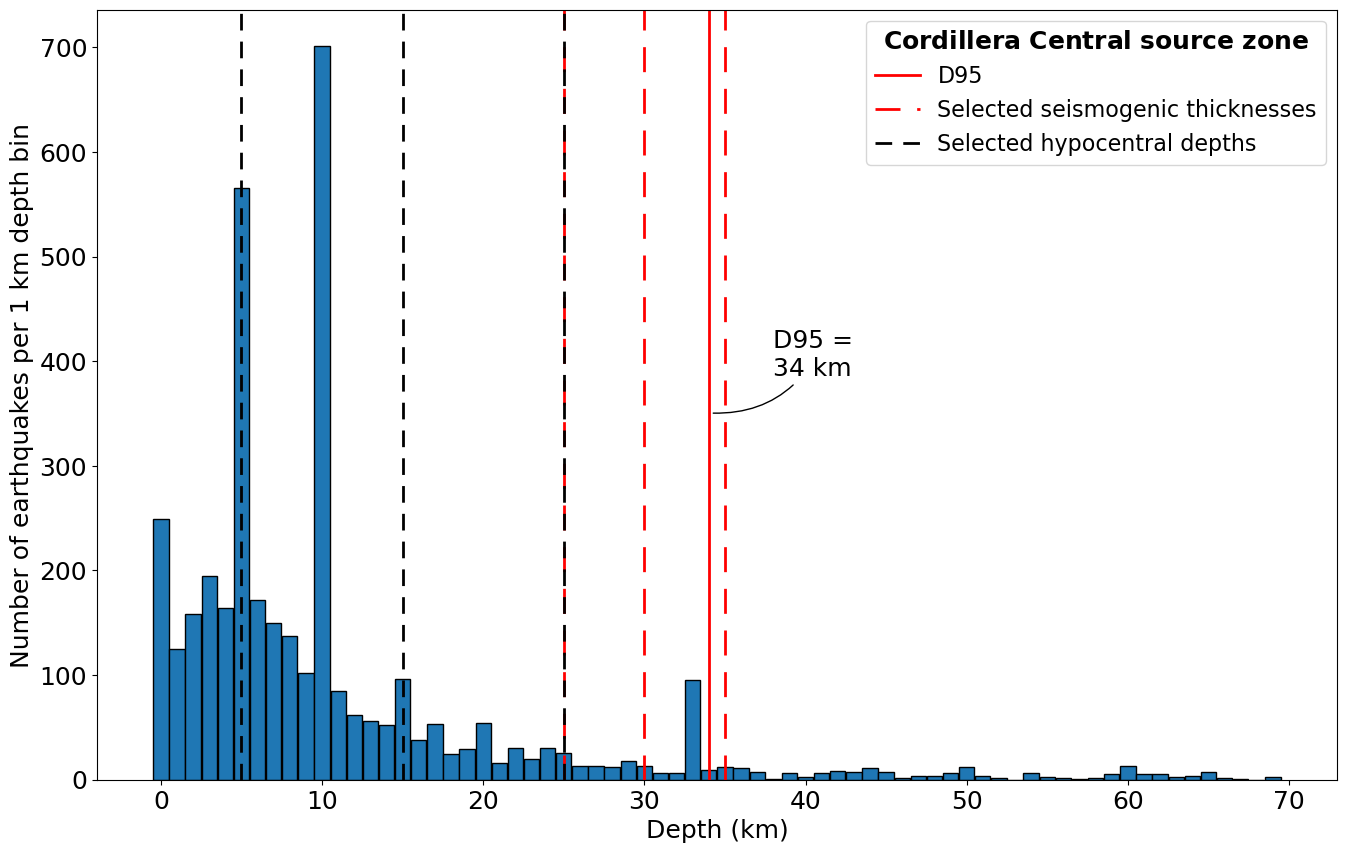

In [8]:
from openquake.hmtk.plotting.seismicity.catalogue_plots import *
figure_dir = os.path.join(userdir,'WSP O365','NZ Project - WSP Chile_Las Tortolas and Perez Caldera (6-DY091.00) - PSHA','source_model_files','crustal_zones','mfds',str(csv_filename).split('.')[0],cat_choice)

LT_crustal_catalogue=CatalogueSelector(LT_crustal_catalogue, create_copy=True).within_depth_range(lower_depth=1000, upper_depth=None)

for source in s_list:
    polygon_oq = source.get_polygon_object()
    catalogue = source.get_source_catalogue(LT_crustal_catalogue, polygon_oq)
    source.catalogue = catalogue
    
    print(source.name) #,'\n',source.coords,'\n')
    
    if source.name == 'CordilleraC':
    
        # Plot depth histogram and ADD LABEL OR VERTICAL LINE AT 95th PERCENTILE OF DEPTH
        hypo_depths = hypo_depth_dict[source.name]
        seismo_depths = seismo_depth_dict[source.name]
        seismo_95pc = np.percentile(catalogue.data['depth'],95)

        bin_width = 1 # km
        fig, ax = plt.subplots(figsize=(16,10))
        # Create depth range
        if len(catalogue.data['depth']) == 0:
            raise ValueError('No depths reported in catalogue!')
        depth_bins = np.arange(0.,np.max(catalogue.data['depth']) + bin_width,bin_width)
        depth_hist = catalogue.get_depth_distribution(depth_bins,
                                                      normalisation=False,
                                                      bootstrap=None)
        ax.bar(depth_bins[:-1],
               depth_hist,
               width=0.95 * bin_width,
               edgecolor='k')
        
        ax.axvline(x=seismo_95pc, color='r', linestyle='-', linewidth=2, label='D95')
        
        for idx,seismo in enumerate(seismo_depths):
            if idx == 0:
                ax.axvline(x=seismo, color='r', linestyle='--', linewidth=2, dashes=(9, 6), label='Selected seismogenic thicknesses')
            else:
                ax.axvline(x=seismo, color='r', linestyle='--', linewidth=2, dashes=(9, 6), label=None)        
        
        for idx,hypo in enumerate(hypo_depths):
            if idx == 0:
                # ax.axvline(x=hypo, color='k', linestyle='-.', linewidth=2, dashes=(6, 4), label='$z_{hypo}$ ')
                ax.axvline(x=hypo, color='k', linestyle='-.', linewidth=2, dashes=(6, 4), label='Selected hypocentral depths')
            else:
                ax.axvline(x=hypo, color='k', linestyle='-.', linewidth=2, dashes=(6, 4), label=None)


        # ax.text(seismo_95pc+0.5,0.5*max(depth_hist),'D95 = \n'+str(np.around(seismo_95pc,1))+' km')
        ax.annotate('D95 = \n'+str(int(np.around(seismo_95pc,1)))+' km',
                    xy=(seismo_95pc+0.1,0.50*max(depth_hist)),xycoords='data',
                    xytext=(seismo_95pc+4,0.58*max(depth_hist)), textcoords='data',
                    size=18, va="center", ha="left",
                    arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=-0.3"))
        

        ax.set_xlabel('Depth (km)')
        ax.set_ylabel('Number of earthquakes per 1 km depth bin')
        if source.name == 'CordilleraC':
            ax.legend(title="$\\bf{Cordillera\ Central\ source\ zone}$",title_fontsize=18,loc='upper right',fontsize=16)
        else:
            ax.legend(loc='upper right')
        # if source.name == 'Coastal':
        # ax.set_title(cat_choice.capitalize()+' Catalogue, '+source.name)

        fig.savefig(os.path.join(figure_dir,str(source.name)+'_depth_hist_'+cat_choice+'.png'), format='PNG', dpi=300, bbox_inches='tight')
    
    

## Estimate Recurrence Parameters

In [11]:
recurrence_estimator = Weichert()

# set recurrence configuration for calculate method
recurrence_config = {"magnitude_interval": 0.1, 
                     'reference_magnitude' : 0.0, 
                     'bvalue' : 1.0, # initial guess for b-value
                     'itstab': 1E-5, # the difference in b-value in order to reach convergence
                     'maxiter' : 1000} # max number of iterations

tmr_dict_L = {}
tmr_dict_P = {}
tmr_dict_U = {}
tmr_dict_LPU = {}

# loop through dictionary and estinmate recurrence parameters for each segment
for source in s_list:
    cat = source.catalogue
    print(source.name, cat.get_number_events())
    
    source.b_val, source.bval_sigma, source.a_val, source.aval_sigma = recurrence_estimator.calc(cat,
                                                              recurrence_config,
                                                              completeness_table)
   

    b,bsig,rate,ratesig,a,asig = recurrence_estimator._calculate(cat,recurrence_config,completeness_table)
    
    
    print(f'b = {b} +/- {bsig}, rate = {rate} +/- {ratesig}, a = {a} +/- {asig}')
    print(a,10**a)

    
    
    aval_2sig = source.aval_sigma*2
    bval_2sig = source.bval_sigma*2
    
    source.aval_sigma = aval_2sig
    source.bval_sigma = bval_2sig
    
    # if source.name == 'CoastalC_Deep':
    #     source.a_val = 4.0
    #     source.aval_sigma = 0.1
    #     source.b_val = 1
    #     source.bval_sigma = 0.2
    
    # print("a = %.3f (+/- %.3f),  b = %.3f (+/-%.3f)" % (source.a_val, source.aval_sigma, source.b_val, source.bval_sigma))
    # print("a = %.10f (+/- %.10f),  b = %.10f (+/-%.10f)" % (source.a_val, source.aval_sigma, source.b_val, source.bval_sigma))
    
    
    # Calculate cumulative total moment rate 
    maxmag = source.mmax
    minmag = source.mmin
    
    cumN_L = []
    cumN_P = []
    cumN_U = []
    Mw_Mo = []
    for m in np.arange(minmag,maxmag+0.2,0.1):
        a_L = source.a_val-source.aval_sigma
        b_L = source.b_val-source.bval_sigma
        a_P = source.a_val
        b_P = source.b_val
        a_U = source.a_val+source.aval_sigma
        b_U = source.b_val+source.bval_sigma        
        
        if m > maxmag+0.1:
            cumN_L.append(0)
            cumN_P.append(0)
            cumN_U.append(0)
        else:
            cumN_L.append(10**(a_L-(b_L*m)))
            cumN_P.append(10**(a_P-(b_P*m)))
            cumN_U.append(10**(a_U-(b_U*m)))
        Mw_Mo.append(10**(1.5*m+9.1))
        
            
    noncumN_L = []
    noncumN_P = []
    noncumN_U = []
    for i,m in enumerate(np.arange(minmag,maxmag+0.1,0.1)):
        if cumN_L[i] == 0:
            noncumN_L.append(0)
        if cumN_P[i] == 0:
            noncumN_P.append(0)
        if cumN_U[i] == 0:
            noncumN_U.append(0)
        else:
            noncumN_L.append(cumN_L[i]-cumN_L[i+1]) 
            noncumN_P.append(cumN_P[i]-cumN_P[i+1]) 
            noncumN_U.append(cumN_U[i]-cumN_U[i+1]) 
    
    noncumMorate_L = []
    noncumMorate_P = []
    noncumMorate_U = []
    for i,m in enumerate(np.arange(minmag,maxmag+0.1,0.1)):
        noncumMorate_L.append(noncumN_L[i]*Mw_Mo[i])
        noncumMorate_P.append(noncumN_P[i]*Mw_Mo[i])
        noncumMorate_U.append(noncumN_U[i]*Mw_Mo[i])
        
    # print('Mmax =',np.arange(minmag,maxmag+0.1,0.1)[-1])
    total_Mo_rate_L = sum(noncumMorate_L)
    total_Mo_rate_P = sum(noncumMorate_P)
    total_Mo_rate_U = sum(noncumMorate_U)
    total_Mo_rate_LPU = (0.2*total_Mo_rate_L)+(0.6*total_Mo_rate_P)+(0.2*total_Mo_rate_U)

    print("Total Mo' (lower) =",total_Mo_rate_L)        
    tmr_dict_L[source.name] = total_Mo_rate_L
    print("Total Mo' (pref) =",total_Mo_rate_P)        
    tmr_dict_P[source.name] = total_Mo_rate_P   
    print("Total Mo' (upper) =",total_Mo_rate_U)        
    tmr_dict_U[source.name] = total_Mo_rate_U
    print("Total Mo' (0.2L+0.6P+0.2L) =",total_Mo_rate_LPU,'\n')        
    tmr_dict_LPU[source.name] = total_Mo_rate_LPU

print(tmr_dict_L)
print(tmr_dict_P)
print(tmr_dict_U)
print(tmr_dict_LPU)

CoastalS 1914
b = 1.0436406193297711 +/- 0.033110147906554414, rate = 885276.5531744245 +/- 31697.985368328315, a = 5.947078961947159 +/- 0.015278314918170999
5.947078961947159 885276.5531744254
Total Mo' (lower) = 2.7988225889584824e+19
Total Mo' (pref) = 1.0680491971015862e+19
Total Mo' (upper) = 4.145204217148751e+18
Total Mo' (0.2L+0.6P+0.2L) = 1.2834981203956234e+19 

SierrasPampeanas 671
b = 0.8835909020939264 +/- 0.042592642633620476, rate = 64061.90723046986 +/- 3638.471833598296, a = 4.806599864195719 +/- 0.023991236172914654
4.806599864195719 64061.90723046979
Total Mo' (lower) = 3.332788295574713e+19
Total Mo' (pref) = 9.578017952919278e+18
Total Mo' (upper) = 2.780026063192932e+18
Total Mo' (0.2L+0.6P+0.2L) = 1.2968392575539579e+19 

CordilleraN 343
b = 0.9517548491835028 +/- 0.09788113992120945, rate = 28603.465035336103 +/- 3494.4694300320157, a = 4.4564186469253215 +/- 0.05005843908842156
4.4564186469253215 28603.465035336074
Total Mo' (lower) = 2.5984779849995223e+19
To

## Plot MFD for Each Source

ValueError: b-value -0.0187766 must be non-negative

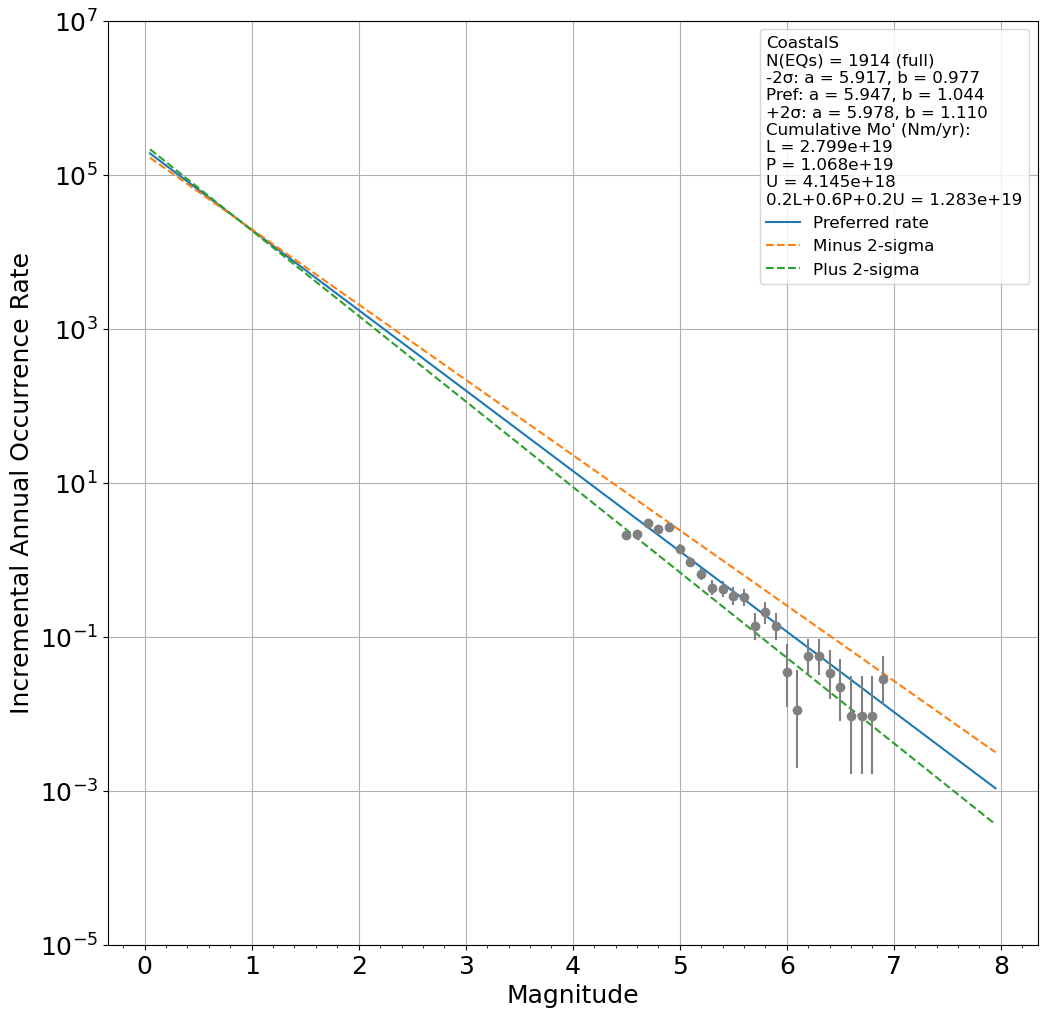

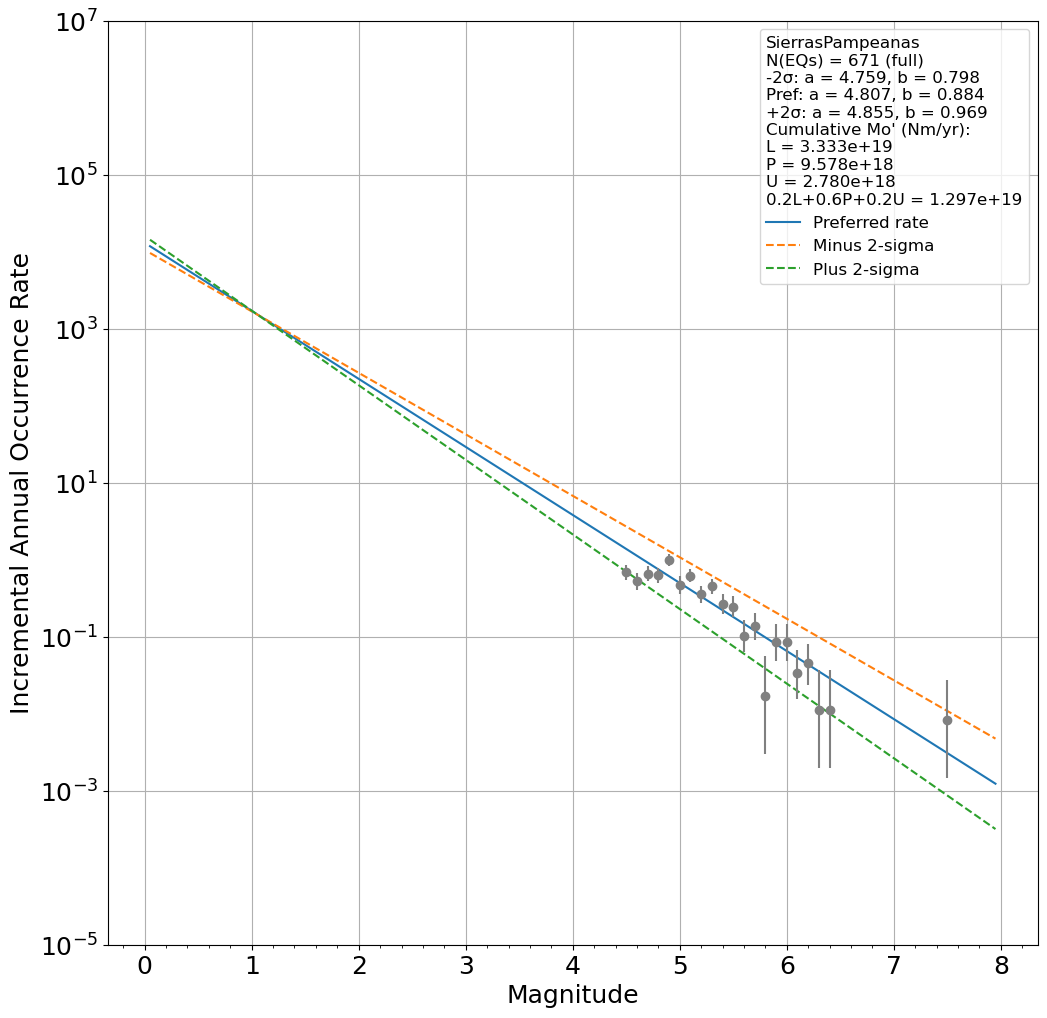

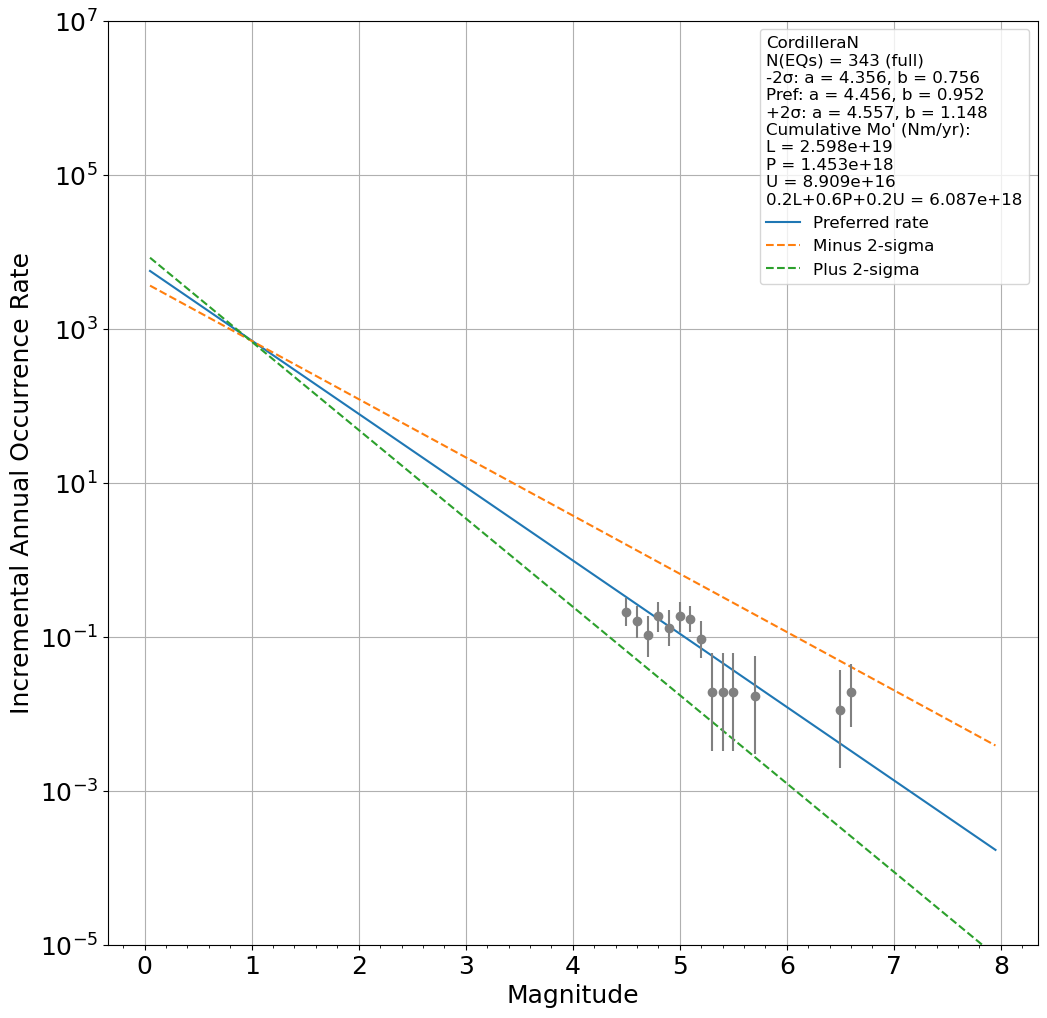

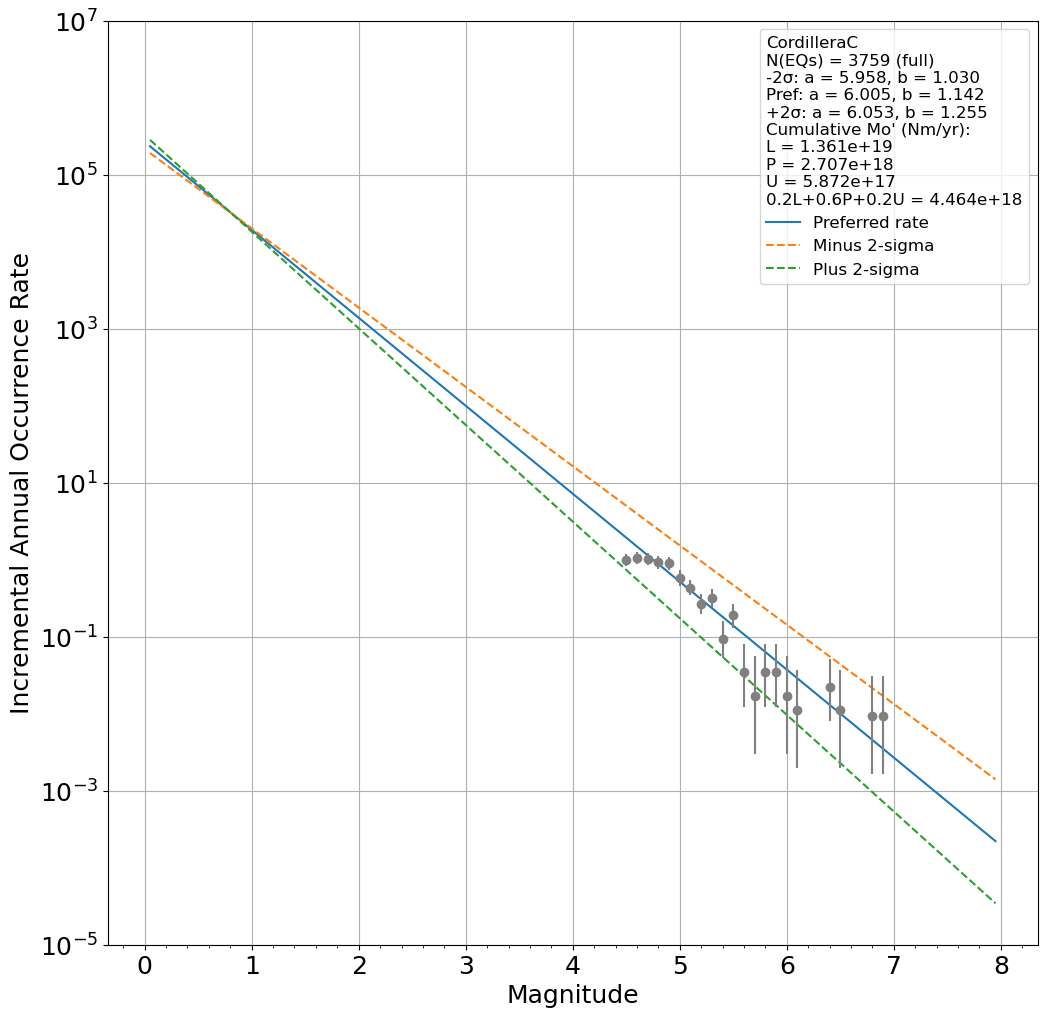

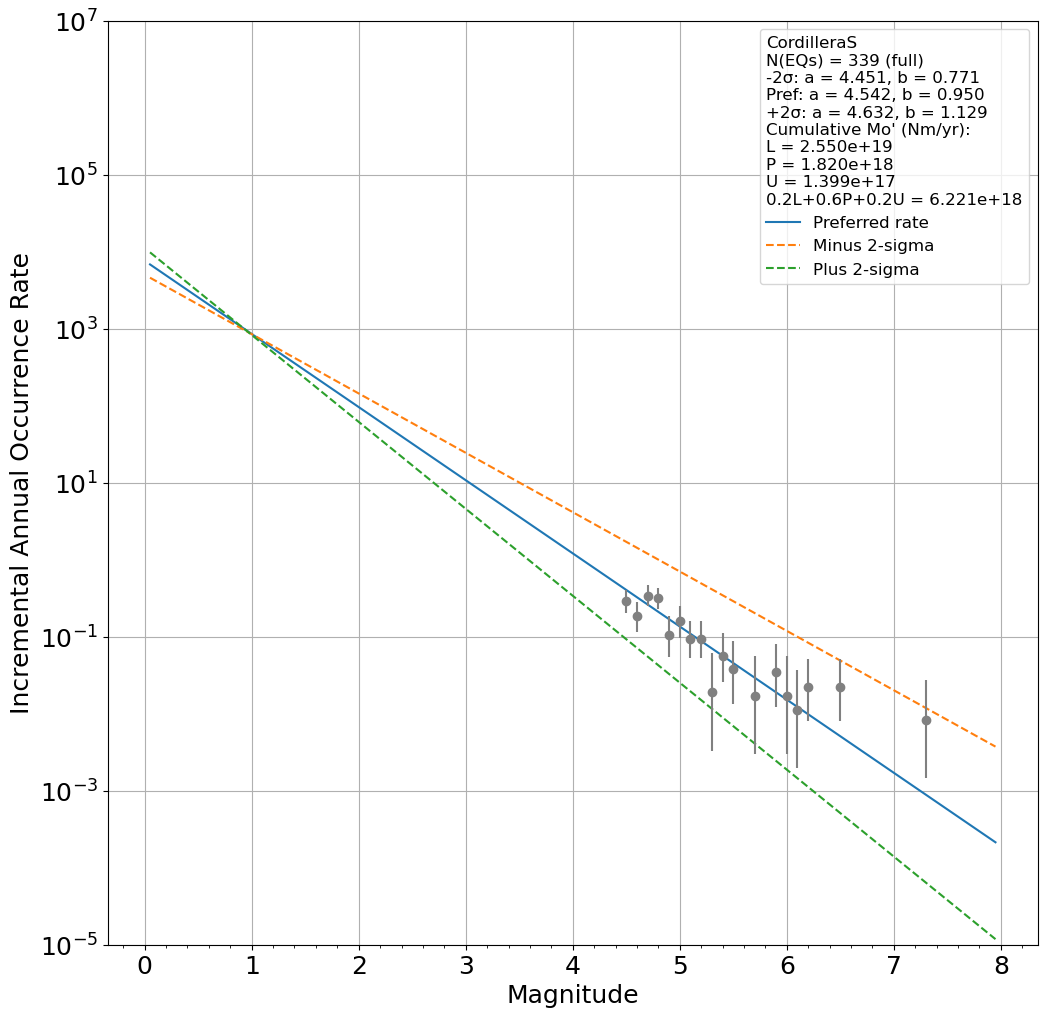

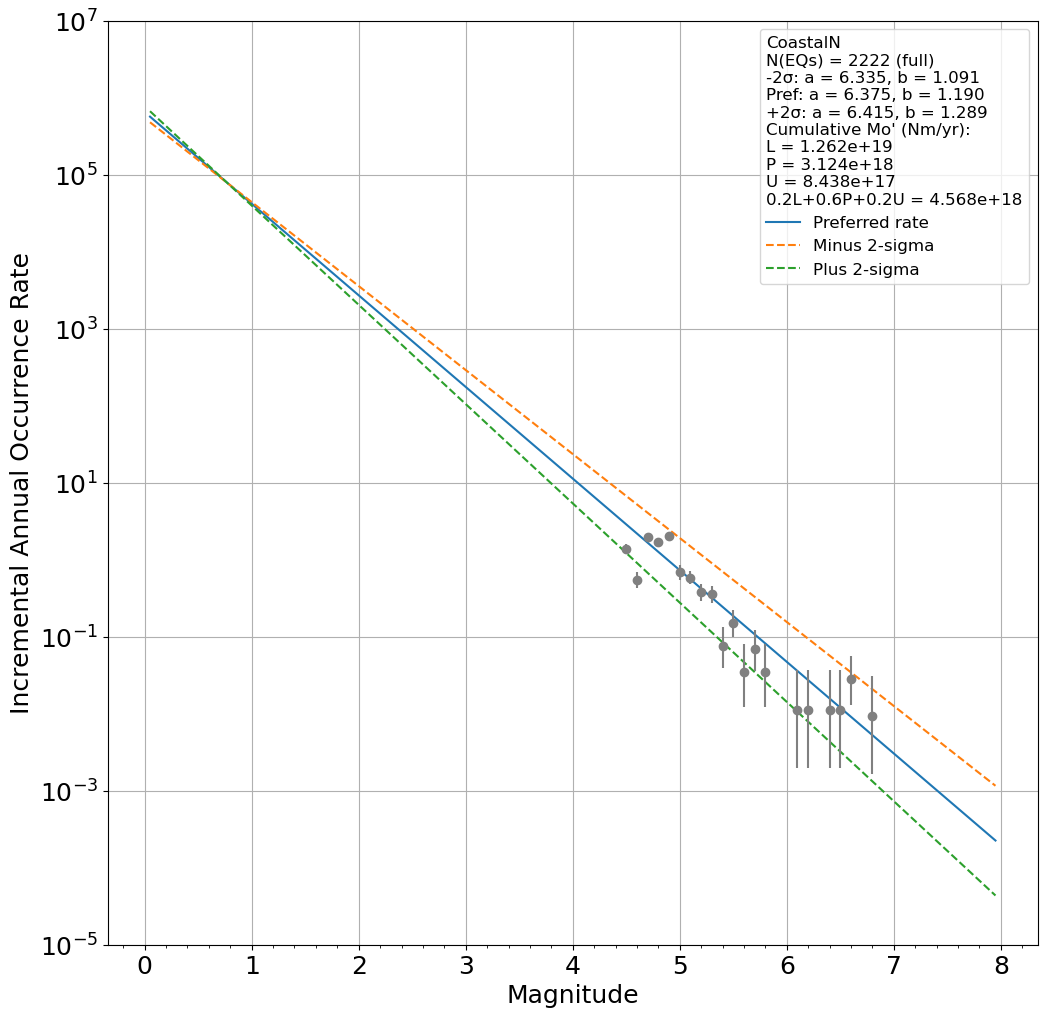

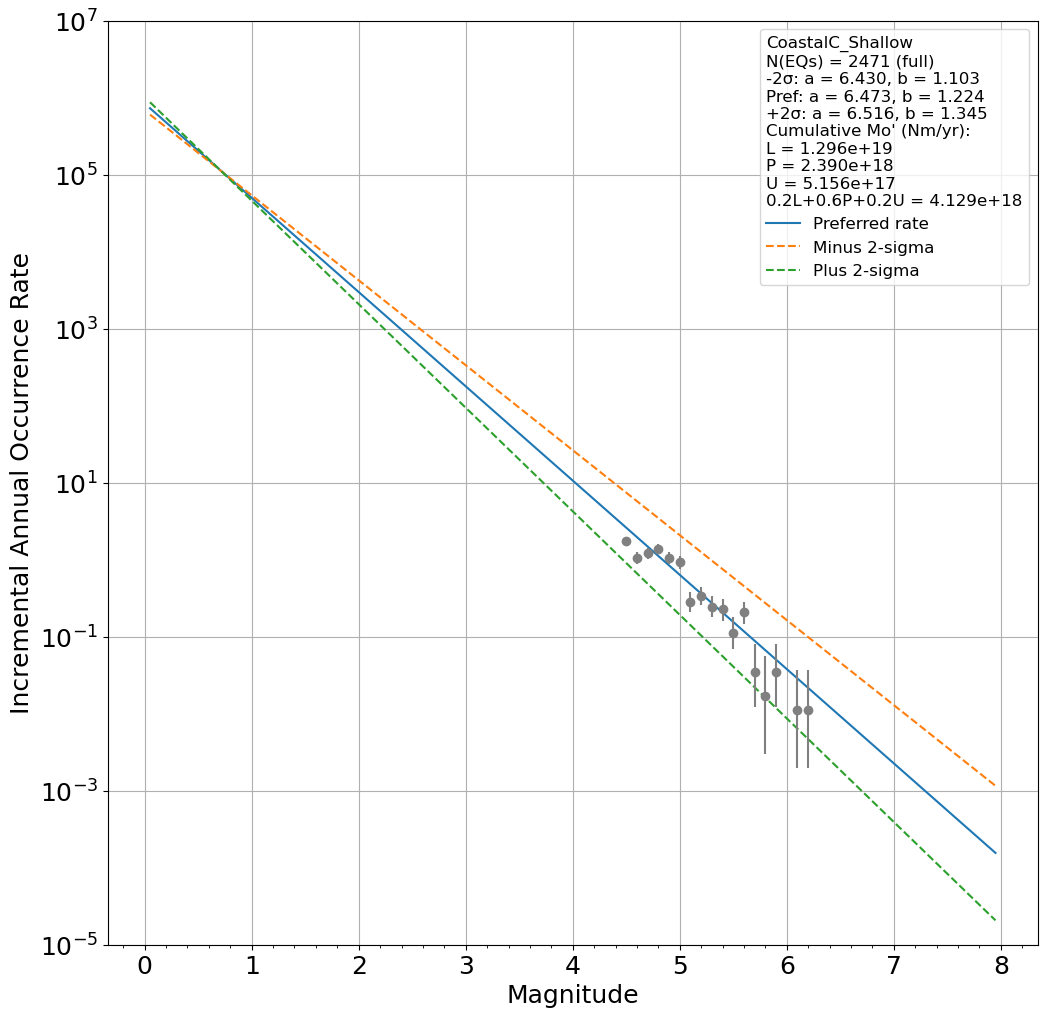

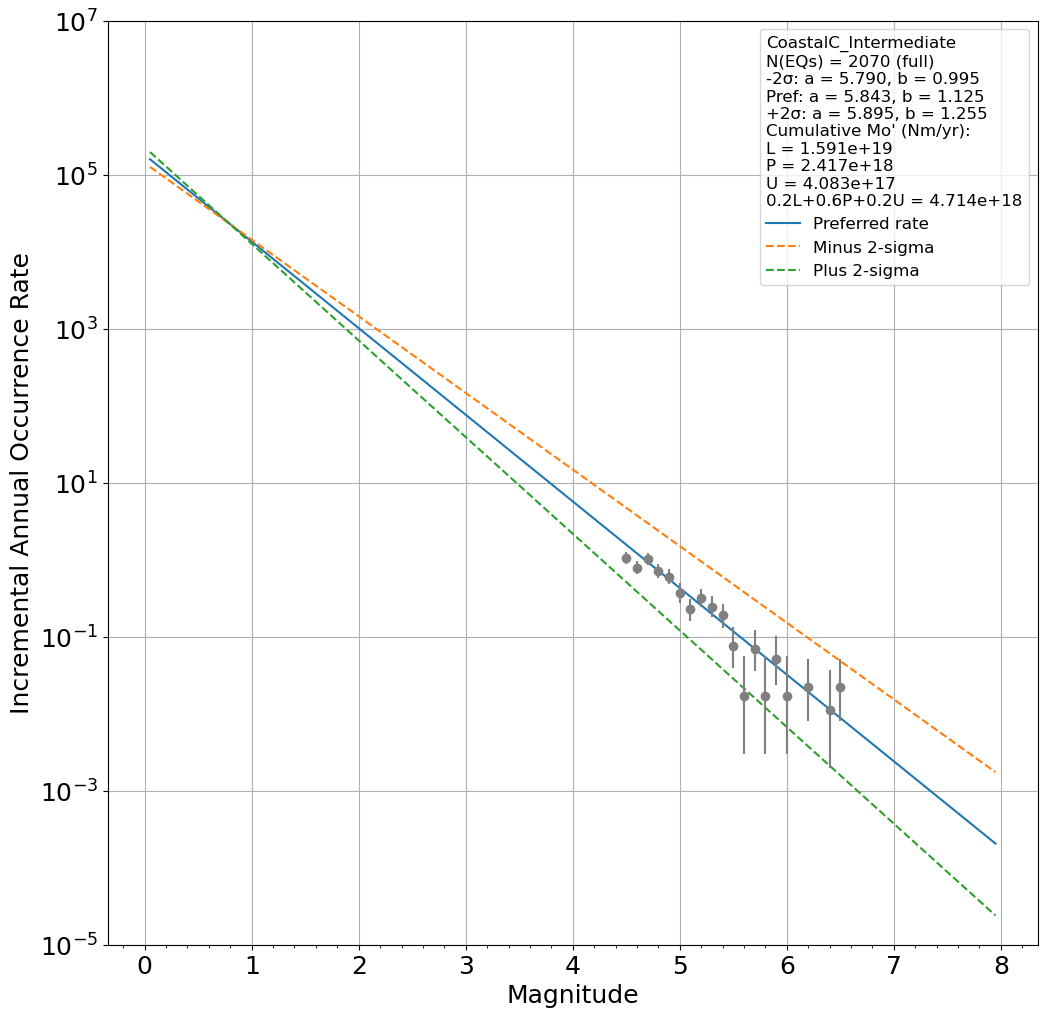

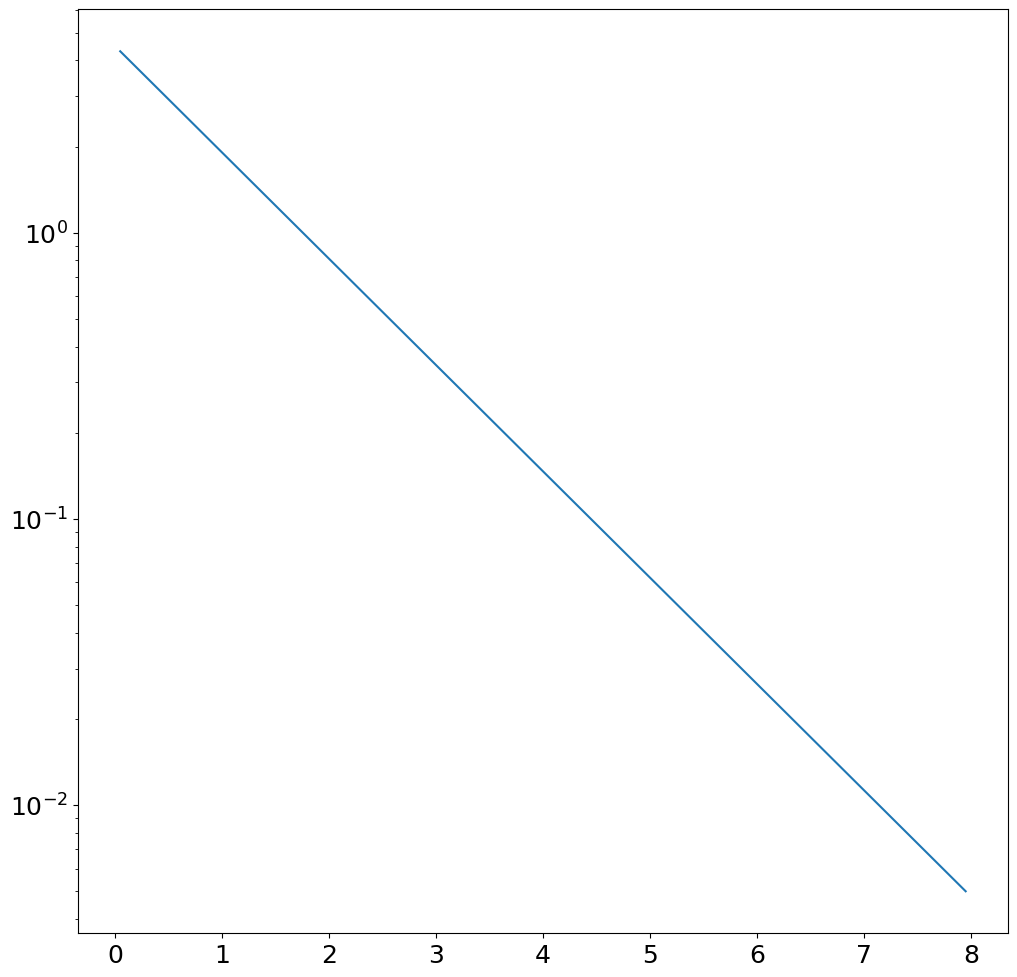

In [12]:
import matplotlib.pyplot as plt
from openquake.hazardlib.mfd.truncated_gr import TruncatedGRMFD

# MANUAL INPUT!
year_start = 1700
year_end = 2023
mmin = 4.5
mmax = 8.0

# produce figure for each source
for source in s_list:
    # set up plot
    fig, ax = plt.subplots(figsize=[12,12])

    # add calculated occurrence rates to plot
    # add mean
    magnitudes, rates = source.get_annual_occurrence_from_ab()
    source.add_plot(ax, 'Preferred rate', magnitudes, rates, 'solid')
    source_a_val_tmp = source.a_val
    source_a_sig_tmp = source.aval_sigma
    source_b_val_tmp = source.b_val
    source_b_sig_tmp = source.bval_sigma

    # add upper and lower bounds to plot
    ab_up, ab_low = source.get_upper_and_lower_ab()
    source_low = source
    source_low.a_val = ab_low[0]
    source_low.b_val = ab_up[1]
    magnitudes_low, rates_low = source_low.get_annual_occurrence_from_ab()
    source_low.add_plot(ax, 'Minus 2-sigma', magnitudes_low, rates_low, 'dashed')
    source_up = source
    source_up.a_val = ab_up[0]
    source_up.b_val = ab_low[1]
    magnitudes_up, rates_up = source_up.get_annual_occurrence_from_ab()
    source_up.add_plot(ax, 'Plus 2-sigma', magnitudes_up, rates_up, 'dashed')
    
    # get incremental values and error bars
    mag_bins, as_count, yerr_t_up, yerr_t_down = source.get_annual_occurrence_from_cat(year_start, year_end, mmin, mmax, 
                                                                             completeness_table)
    
    # plot values
    ax.errorbar(mag_bins, as_count, yerr=[list(yerr_t_down),list(yerr_t_up)], fmt='o', color='grey')    

    # plot styling
    ax.legend(title=str(source.name)+"\nN(EQs) = "+str(len(source.catalogue))+" ("+str(cat_choice)+")\n-2"+"\u03C3"+": a = "+str(format(round(source_a_val_tmp-source_a_sig_tmp,3),'.3f'))+", b = "+str(format(round(source_b_val_tmp-source_b_sig_tmp,3),'.3f'))+"\nPref: a = "+str(format(round(source_a_val_tmp,3),'.3f'))+", b = "+str(format(round(source_b_val_tmp,3),'.3f'))+"\n+2"+"\u03C3"+": a = "+str(format(round(source_a_val_tmp+source_a_sig_tmp,3),'.3f'))+", b = "+str(format(round(source_b_val_tmp+source_b_sig_tmp,3),'.3f'))+"\nCumulative Mo' (Nm/yr):\nL = "+str(format(tmr_dict_L[source.name],'.3e'))+"\nP = "+str(format(tmr_dict_P[source.name],'.3e'))+"\nU = "+str(format(tmr_dict_U[source.name],'.3e'))+"\n0.2L+0.6P+0.2U = "+str(format(tmr_dict_LPU[source.name],'.3e')),loc='upper right',alignment='left',title_fontsize=12,fontsize=12)
    ax.grid()
    ax.minorticks_on()
    ax.set_ylim(10e-6,10e6)
    ax.set_ylabel('Incremental Annual Occurrence Rate')
    ax.set_xlabel('Magnitude')
    fig.savefig(os.path.join(userdir,'WSP O365','NZ Project - WSP Chile_Las Tortolas and Perez Caldera (6-DY091.00) - PSHA','source_model_files','crustal_zones','mfds',str(csv_filename).split('.')[0],cat_choice,str(source.name).replace(" ", "")+"_"+str(cat_choice)+".png"), format='PNG', dpi=300, bbox_inches='tight')

## Input judgement-based a- and b-values

In [19]:
# Select source zone to analyse

source_zone_choice = "CordilleraC" 

------------------------
Source name = CordilleraC
Existing a-value =  6.005442548236 ± 0.047610424814
Existing b-value =  1.142326125692 ± 0.112706490087
Existing Total Mo' (lower) = 1.3610616741861505e+19
Existing Total Mo' (pref) = 2.7069586978686986e+18
Existing Total Mo' (upper) = 5.871662568331649e+17
Existing Total Mo' (weighted combination) = 4.4637318184601533e+18 



Enter judgement-based a-value:  6
Enter judgement-based a-value 2-sigma:  0.1
Enter judgement-based b-value:  1.15
Enter judgement-based b-value 2-sigma:  0.14


New Total Mo' (lower) = 1.6174340156061827e+19
% difference (lower) = 18.836203111319737
New Total Mo' (pref) = 2.3831143081666314e+18
% difference (pref) = -11.963403429725151
New Total Mo' (upper) = 4.0475376259747014e+17
% difference (upper) = -31.066583290995336
New Total Mo' (weighted combination) = 4.745687368631839e+18
% difference (weighted combination) = 6.316588039757083 



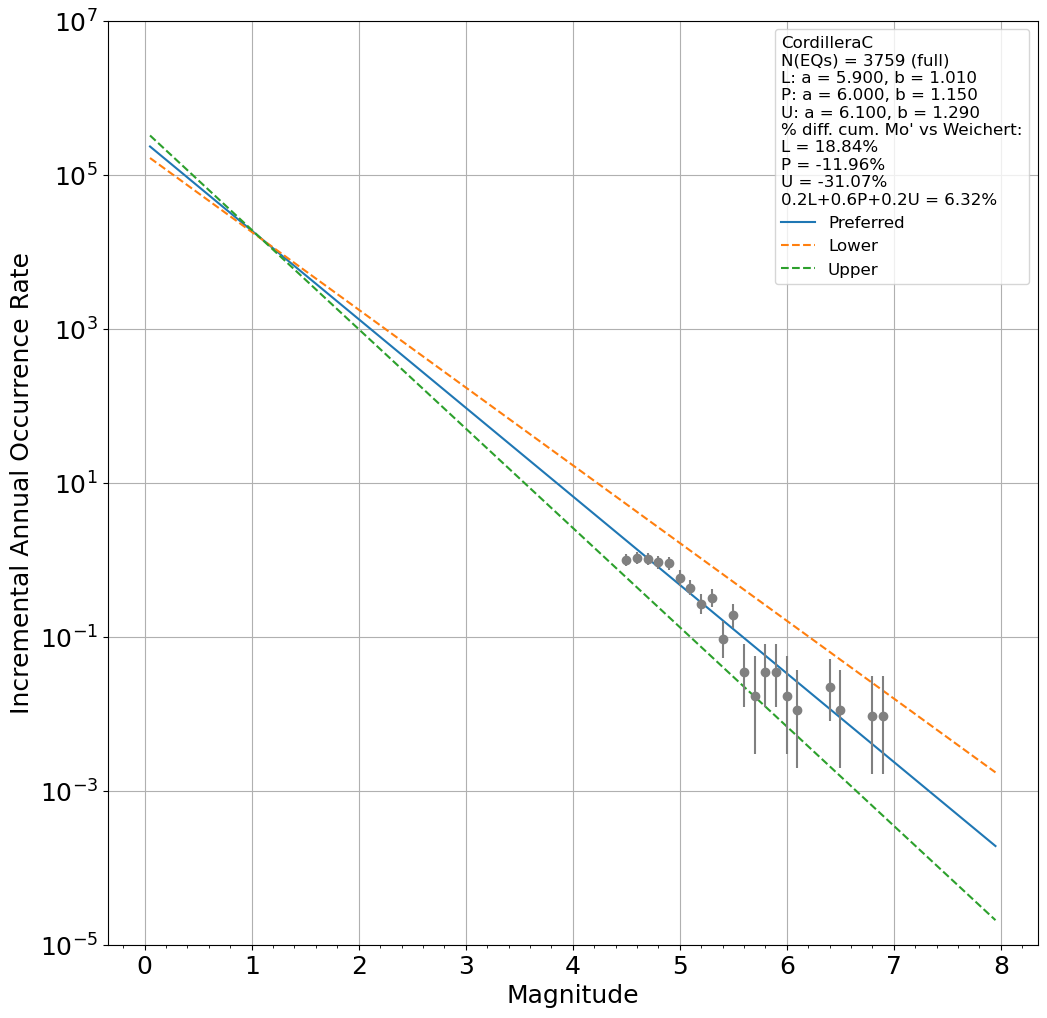

In [20]:
# Get Weichert estimates of a- and b-values for each source

recurrence_estimator = Weichert()

# set recurrence configuration for calculate method
recurrence_config = {"magnitude_interval": 0.1, 
                     'reference_magnitude' : 0.0, 
                     'bvalue' : 1.0, # initial guess for b-value
                     'itstab': 1E-5, # the difference in b-value in order to reach convergence
                     'maxiter' : 1000} # max number of iterations

# loop through dictionary and estinmate recurrence parameters for each segment
for source in s_list:
    cat = source.catalogue
    
    source.b_val, source.bval_sigma, source.a_val, source.aval_sigma = recurrence_estimator.calc(cat,
                                                              recurrence_config,
                                                              completeness_table)
    
    aval_2sig = source.aval_sigma*2
    bval_2sig = source.bval_sigma*2
    
    source.aval_sigma = aval_2sig
    source.bval_sigma = bval_2sig
    
##################################################################################################################
    
# Set judgement-based a- and b-values for zone of choice
    
for source in s_list:
    if source.name == source_zone_choice:
        print("------------------------")
        print("Source name =",source.name)
        # print("Existing a-value = ",round(source.a_val,3),"\u00B1",round(source.aval_sigma,3))
        # print("Existing b-value = ",round(source.b_val,3),"\u00B1",round(source.bval_sigma,3))
        print("Existing a-value = ",round(source.a_val,12),"\u00B1",round(source.aval_sigma,12))
        print("Existing b-value = ",round(source.b_val,12),"\u00B1",round(source.bval_sigma,12))
        
        # Print existing cumulative total moment rate 
        maxmag = source.mmax
        minmag = source.mmin

        cumN_L = []
        cumN_P = []
        cumN_U = []
        Mw_Mo = []
        for m in np.arange(minmag,maxmag+0.2,0.1):
            a_L = source.a_val-source.aval_sigma
            b_L = source.b_val-source.bval_sigma
            a_P = source.a_val
            b_P = source.b_val
            a_U = source.a_val+source.aval_sigma
            b_U = source.b_val+source.bval_sigma        

            if m > maxmag+0.1:
                cumN_L.append(0)
                cumN_P.append(0)
                cumN_U.append(0)
            else:
                cumN_L.append(10**(a_L-(b_L*m)))
                cumN_P.append(10**(a_P-(b_P*m)))
                cumN_U.append(10**(a_U-(b_U*m)))
            Mw_Mo.append(10**(1.5*m+9.1))

            
        noncumN_L = []
        noncumN_P = []
        noncumN_U = []
        for i,m in enumerate(np.arange(minmag,maxmag+0.1,0.1)):
            if cumN_L[i] == 0:
                noncumN_L.append(0)
            if cumN_P[i] == 0:
                noncumN_P.append(0)
            if cumN_U[i] == 0:
                noncumN_U.append(0)
            else:
                noncumN_L.append(cumN_L[i]-cumN_L[i+1]) 
                noncumN_P.append(cumN_P[i]-cumN_P[i+1]) 
                noncumN_U.append(cumN_U[i]-cumN_U[i+1])

        noncumMorate_L = []
        noncumMorate_P = []
        noncumMorate_U = []
        for i,m in enumerate(np.arange(minmag,maxmag+0.1,0.1)):
            noncumMorate_L.append(noncumN_L[i]*Mw_Mo[i])
            noncumMorate_P.append(noncumN_P[i]*Mw_Mo[i])
            noncumMorate_U.append(noncumN_U[i]*Mw_Mo[i])

        
        total_Mo_rate_existing_L = sum(noncumMorate_L)
        print("Existing Total Mo' (lower) =",total_Mo_rate_existing_L)   
        total_Mo_rate_existing_P = sum(noncumMorate_P)
        print("Existing Total Mo' (pref) =",total_Mo_rate_existing_P)
        total_Mo_rate_existing_U = sum(noncumMorate_U)
        print("Existing Total Mo' (upper) =",total_Mo_rate_existing_U)
        total_Mo_rate_existing_LPU = (0.2*total_Mo_rate_existing_L)+(0.6*total_Mo_rate_existing_P)+(0.2*total_Mo_rate_existing_U)
        print("Existing Total Mo' (weighted combination) =",total_Mo_rate_existing_LPU,'\n')

        
        # ------------------------------------------------------------------------------------

        source.a_val = float(input("Enter judgement-based a-value: "))
        source.aval_sigma = float(input("Enter judgement-based a-value 2-sigma: "))
        source.b_val = float(input("Enter judgement-based b-value: "))
        source.bval_sigma = float(input("Enter judgement-based b-value 2-sigma: "))
        
        
        # Print new cumulative total moment rate 
        maxmag = source.mmax
        minmag = source.mmin

        cumN_L = []
        cumN_P = []
        cumN_U = []
        Mw_Mo = []
        for m in np.arange(minmag,maxmag+0.2,0.1):
            a_L = source.a_val-source.aval_sigma
            b_L = source.b_val-source.bval_sigma
            a_P = source.a_val
            b_P = source.b_val
            a_U = source.a_val+source.aval_sigma
            b_U = source.b_val+source.bval_sigma        

            if m > maxmag+0.1:
                cumN_L.append(0)
                cumN_P.append(0)
                cumN_U.append(0)
            else:
                cumN_L.append(10**(a_L-(b_L*m)))
                cumN_P.append(10**(a_P-(b_P*m)))
                cumN_U.append(10**(a_U-(b_U*m)))
            Mw_Mo.append(10**(1.5*m+9.1))

            
        noncumN_L = []
        noncumN_P = []
        noncumN_U = []
        for i,m in enumerate(np.arange(minmag,maxmag+0.1,0.1)):
            if cumN_L[i] == 0:
                noncumN_L.append(0)
            if cumN_P[i] == 0:
                noncumN_P.append(0)
            if cumN_U[i] == 0:
                noncumN_U.append(0)
            else:
                noncumN_L.append(cumN_L[i]-cumN_L[i+1]) 
                noncumN_P.append(cumN_P[i]-cumN_P[i+1]) 
                noncumN_U.append(cumN_U[i]-cumN_U[i+1])

        noncumMorate_L = []
        noncumMorate_P = []
        noncumMorate_U = []
        for i,m in enumerate(np.arange(minmag,maxmag+0.1,0.1)):
            noncumMorate_L.append(noncumN_L[i]*Mw_Mo[i])
            noncumMorate_P.append(noncumN_P[i]*Mw_Mo[i])
            noncumMorate_U.append(noncumN_U[i]*Mw_Mo[i])

        total_Mo_rate_new_L = sum(noncumMorate_L)
        print("New Total Mo' (lower) =",total_Mo_rate_new_L)  
        total_Mo_rate_pcdiff_L = ((total_Mo_rate_new_L-total_Mo_rate_existing_L)/total_Mo_rate_existing_L)*100
        print("% difference (lower) =",total_Mo_rate_pcdiff_L)
        
        total_Mo_rate_new_P = sum(noncumMorate_P)
        print("New Total Mo' (pref) =",total_Mo_rate_new_P)  
        total_Mo_rate_pcdiff_P = ((total_Mo_rate_new_P-total_Mo_rate_existing_P)/total_Mo_rate_existing_P)*100
        print("% difference (pref) =",total_Mo_rate_pcdiff_P)        
        
        total_Mo_rate_new_U = sum(noncumMorate_U)
        print("New Total Mo' (upper) =",total_Mo_rate_new_U)  
        total_Mo_rate_pcdiff_U = ((total_Mo_rate_new_U-total_Mo_rate_existing_U)/total_Mo_rate_existing_U)*100
        print("% difference (upper) =",total_Mo_rate_pcdiff_U)        
        
        total_Mo_rate_new_LPU = (0.2*total_Mo_rate_new_L)+(0.6*total_Mo_rate_new_P)+(0.2*total_Mo_rate_new_U)
        print("New Total Mo' (weighted combination) =",total_Mo_rate_new_LPU)  
        total_Mo_rate_pcdiff_LPU = ((total_Mo_rate_new_LPU-total_Mo_rate_existing_LPU)/total_Mo_rate_existing_LPU)*100
        print("% difference (weighted combination) =",total_Mo_rate_pcdiff_LPU,'\n')
        
        
# Plot MFD with judgement-based a- and b-values        

        # set up plot
        fig, ax = plt.subplots(figsize=[12,12])

        # add calculated occurrence rates to plot
        # add mean
        magnitudes, rates = source.get_annual_occurrence_from_ab()
        source.add_plot(ax, 'Preferred', magnitudes, rates, 'solid')
        source_a_val_tmp = source.a_val
        source_a_sig_tmp = source.aval_sigma
        source_b_val_tmp = source.b_val
        source_b_sig_tmp = source.bval_sigma

        # add upper and lower bounds to plot
        ab_up, ab_low = source.get_upper_and_lower_ab()
        source_low = source
        source_low.a_val = ab_low[0]
        source_low.b_val = ab_up[1]
        magnitudes_low, rates_low = source_low.get_annual_occurrence_from_ab()
        source_low.add_plot(ax, 'Lower', magnitudes_low, rates_low, 'dashed')
        source_up = source
        source_up.a_val = ab_up[0]
        source_up.b_val = ab_low[1]
        magnitudes_up, rates_up = source_up.get_annual_occurrence_from_ab()
        source_up.add_plot(ax, 'Upper', magnitudes_up, rates_up, 'dashed')

        # get incremental values and error bars
        mag_bins, as_count, yerr_t_up, yerr_t_down = source.get_annual_occurrence_from_cat(year_start, year_end, mmin, mmax, 
                                                                                 completeness_table)

        # plot values
        ax.errorbar(mag_bins, as_count, yerr=[list(yerr_t_down),list(yerr_t_up)], fmt='o', color='grey')    

        # plot styling
        if source.name == 'CoastalC_Deep':
            ax.legend(title=str(source.name)+"\nN(EQs) = "+str(len(source.catalogue))+" ("+str(cat_choice)+")\nL: a = "+str(format(round(source_a_val_tmp-source_a_sig_tmp,3),'.3f'))+", b = "+str(format(round(source_b_val_tmp-source_b_sig_tmp,3),'.3f'))+"\nP: a = "+str(format(round(source_a_val_tmp,3),'.3f'))+", b = "+str(format(round(source_b_val_tmp,3),'.3f'))+"\nU: a = "+str(format(round(source_a_val_tmp+source_a_sig_tmp,3),'.3f'))+", b = "+str(format(round(source_b_val_tmp+source_b_sig_tmp,3),'.3f')),loc='upper right',alignment='left',title_fontsize=12,fontsize=12)
        else:
            ax.legend(title=str(source.name)+"\nN(EQs) = "+str(len(source.catalogue))+" ("+str(cat_choice)+")\nL: a = "+str(format(round(source_a_val_tmp-source_a_sig_tmp,3),'.3f'))+", b = "+str(format(round(source_b_val_tmp-source_b_sig_tmp,3),'.3f'))+"\nP: a = "+str(format(round(source_a_val_tmp,3),'.3f'))+", b = "+str(format(round(source_b_val_tmp,3),'.3f'))+"\nU: a = "+str(format(round(source_a_val_tmp+source_a_sig_tmp,3),'.3f'))+", b = "+str(format(round(source_b_val_tmp+source_b_sig_tmp,3),'.3f'))+"\n% diff. cum. Mo' vs Weichert:\nL = "+str(format(round(total_Mo_rate_pcdiff_L,2),'.2f'))+"%\nP = "+str(format(round(total_Mo_rate_pcdiff_P,2),'.2f'))+"%\nU = "+str(format(round(total_Mo_rate_pcdiff_U,2),'.2f'))+"%\n0.2L+0.6P+0.2U = "+str(format(round(total_Mo_rate_pcdiff_LPU,2),'.2f'))+"%",loc='upper right',alignment='left',title_fontsize=12,fontsize=12)
        ax.grid()
        ax.minorticks_on()
        ax.set_ylim(10e-6,10e6)
        ax.set_ylabel('Incremental Annual Occurrence Rate')
        ax.set_xlabel('Magnitude')
        fig.savefig(os.path.join(userdir,'WSP O365','NZ Project - WSP Chile_Las Tortolas and Perez Caldera (6-DY091.00) - PSHA','source_model_files','crustal_zones','mfds',str(csv_filename).split('.')[0],cat_choice,str(source.name).replace(" ", "")+"_"+str(cat_choice)+"_judgement.png"), format='PNG', dpi=300, bbox_inches='tight')

# Splitting the catalogue into sub-sets : the Selector Class

The optional keyword `create_copy` ensures that when the events not selected are purged
from the catalogue a `“deepcopy”` is taken of the original catalogue. This ensures that the original
catalogue remains unmodified when a subset of events is selected.

The catalogue selector class has the following methods:  
>`.within_polygon(polygon, distance=None)`
>Selects events within a polygon described by the class `openquake.hazardlib.geo.
>polygon.Polygon.` distance is the distance (in km) to use as a buffer, if required. Optional
>keyword arguments `upper_depth` and `lower_depth` can be used to limit the depth range of
>the catalogue returned by the selector to only those events whose hypocentres are within the
>specified depth limits.  

`.circular_distance_from_point(point, distance, distance_type="epicentral")`
Selects events within a distance from the a location. The location (point) is an instance of
the openquake.hazardlib.point.Point class, whilst distance is the selection distance (km) and
distance_type can be either "epicentral" or "hypocentral".  
`.cartesian_square_centred_on_point(point, distance)`
Selects events within a square of side length distance, on a location (represented as an
openquake Point class).  
`.within_joyner_boore_distance(surface, distance)`
Returns earthquakes within a distance (km) of the surface projection (“Joyner-Boore” distance) of a fault surface. The fault surface must be defined as an instance of the class
openquake.hazardlib.geo.surface.simple_fault.SimpleFaultSurface or
openquake.hazardlib.geo.surface.complex_fault.ComplexFaultSurface.  
`.within_rupture_distance(surface, distance)`
Returns earthquakes within a distance (km) of a fault surface. The fault surface must be
defined as an instance of the class
openquake.hazardlib.geo.surface.simple_fault.SimpleFaultSurface or
openquake.hazardlib.geo.surface.complex_fault.ComplexFaultSurface.  
`.within_time_period(start_time=None, end_time=None)`
`.within_depth_range(lower_depth=None, upper_depth=None)`
Selects earthquakes whose hypocentres are within the range specified by the lower depth
limit (lower_depth) and the upper depth limit (upper_depth), both in km.  
`.within_magnitude_range(lower_mag=None, upper_mag=None)`
Selects earthquakes whose magnitudes are within the range specified by the lower limit
(`lower_mag`) and the upper limit (`upper_mag`).

## Crustal Sources

In [ ]:
cat_type='crustal'
if cat_type == 'crustal':
    polygon_coords = pd.read_csv(r"C:\Users\ewatson\Golder Associates\20396083, CSCEC PNG Kundu Tower Port Moresby - SHA\seismicity_catalogue\inslab_polygons.csv")

    polygon_dictionary = dict.fromkeys(polygon_coords['Source Name'].unique())

    for source in polygon_dictionary.keys():
        tmp_df = polygon_coords.loc[polygon_coords['Source Name'] == source]
        tmp_list = []
        for index,row in tmp_df.iterrows():
            tmp_list.append(Point(row['longitude'],row['latitude'])) #point depth defaults to 0.0

        polygon_dictionary[source] = Polygon(tmp_list)

    #print(polygon_dictionary)

    crustal_sub_catalogues = dict.fromkeys(polygon_dictionary.keys())
    for source,poly in polygon_dictionary.items():
        crustal_sub_catalogues[source] = CatalogueSelector(crustal_catalogue, create_copy=True).within_polygon(poly,distance=None)
        

    for source,thiscatalogue in crustal_sub_catalogues.items():
        num_events = thiscatalogue.get_number_events()
        print(source,num_events)
        
        
        thiscatalogue.get_depth_distribution(depth_bins)
        depth_bin=5.0
        plot_depth_histogram(thiscatalogue,depth_bin)
        
        magnitude_bin = 0.1
        depth_bin = 5.0
        plot_magnitude_depth_density(thiscatalogue,
                             magnitude_bin,
                             depth_bin,logscale=True) 
        #if num_events > 0:
            #depth_bin=5.0
            #plot_depth_histogram(thiscatalogue,depth_bin)
            #plt.show()

else:
    print('Not working on crustal catalogue. Moving on.')

## Slab Sources

In [ ]:
cat_type='slab'
if cat_type == 'slab':

    slab_polygon_coords = pd.read_csv(os.path.join(slab_dir,'slab_coords.csv'))#ordered_coordinates.csv'))


    slab_polygon_dictionary = dict.fromkeys(slab_polygon_coords['SourceName'].unique())

    for source in slab_polygon_dictionary.keys():
        tmp_df = slab_polygon_coords.loc[slab_polygon_coords['SourceName'] == source]
        tmp_list = []
        for index,row in tmp_df.iterrows():
            tmp_list.append(Point(row['lon'],row['lat'])) #point depth defaults to 0.0

        slab_polygon_dictionary[source] = Polygon(tmp_list)

    slab_sub_catalogues = dict.fromkeys(slab_polygon_dictionary.keys())
    for source,poly in slab_polygon_dictionary.items():
        slab_sub_catalogues[source] = CatalogueSelector(slab_catalogue, create_copy=True).within_polygon(poly,distance=None)
        
else:
    print('Not working on slab catalogue. Moving on.')

# Recurrence Models - Weichert 1980

Weichert().calculate returns **10^a** if a reference magnitude is perscribed (default 0.0 returns **10^a**)

To get **a-value** (rather than 10^a), set `reference_magnitude` to `None`

**`reference_magnitude : None` does the following:**  
```python 
if not config['reference_magnitude']:
    rate = np.log10(aval)
    sigma_rate = np.log10(aval + sigma_a) - np.log10(aval)

return bval, sigma_b, rate, sigma_rate
```
**This means that rate = log10(10^a) = a-value**

## Crustal Area Sources

In [ ]:
cat_type = 'crustal'
if cat_type == 'crustal':
    crustal_recurrence_param_dict = dict.fromkeys(crustal_sub_catalogues.keys())

    recurrence_estimator = Weichert()

    recurrence_config = {"magnitude_interval": 0.1, 
                         'reference_magnitude' : 0.0, 
                         'bvalue' : 1.0, # initial guess for b-value
                         'itstab': 1E-5, # the difference in b-value in order to reach convergence
                         'maxiter' : 1000} # max number of iterations

    for source,thiscatalogue in crustal_sub_catalogues.items():
        num_events = thiscatalogue.get_number_events()
        if num_events > 0:
            print(source,num_events)

            
            bval, sigma_b, aval, sigma_a = recurrence_estimator.calculate(thiscatalogue,
                                                                          recurrence_config,
                                                                          completeness_table_a)

            crustal_recurrence_param_dict[source] = {'bval':bval, 'sigma_b':sigma_b, 'aval':aval, 'sigma_a':sigma_a}

            print("a = %.3f (+/- %.3f),  b = %.3f (+/-%.3f)" % (aval, sigma_a, bval, sigma_b))

            this_mmax = 8.5
            this_mmin = 5.0


            mfd0 = TruncatedGRMFD(this_mmin, this_mmax, 0.1, aval, bval)


            annual_rates = mfd0.get_annual_occurrence_rates()
            annual_rates = np.array([[val[0], val[1]] for val in annual_rates])
            annual_rates_only = np.array([val[1] for val in annual_rates])

            cumulative_rates = np.array([np.sum(annual_rates[iloc:, 1])
                                     for iloc in range(0, len(annual_rates), 1)])


            #plot_recurrence_model(mfd0,thiscatalogue,completeness_table_a,0.1)
            #plot_trunc_gr_model(aval, bval, this_mmin, this_mmax, 0.1)

## Slab sources

In [ ]:
cat_type = 'slab'
if cat_type == 'slab':
    
    slab_recurrence_param_dict = dict.fromkeys(slab_polygon_dictionary.keys())


    recurrence_estimator = Weichert()

    recurrence_config = {"magnitude_interval": 0.1, 
                         'reference_magnitude' : 0.0, # To get a-value for an incremental MFD rather than 10^a for cumulative # The remaining parameters are optional
                         'bvalue' : 1.0, # initial guess for b-value
                         'itstab': 1E-5, # the difference in b-value in order to reach convergence
                         'maxiter' : 1000} # max number of iterations

    
    
    for source,thiscatalogue in slab_sub_catalogues.items():
        num_events = thiscatalogue.get_number_events()
        if num_events > 0:
            print(source,num_events)
            
            
            bval, sigma_b, aval, sigma_a = recurrence_estimator.calculate(thiscatalogue, 
                                                              recurrence_config,
                                                              completeness_table_a)
    
            slab_recurrence_param_dict[source] = {'bval':bval, 'sigma_b':sigma_b, 'aval':aval, 'sigma_a':sigma_a}

            print('Source',source, ": a = %.3f (+/- %.3f),  b = %.3f (+/-%.3f)" % (aval, sigma_a, bval, sigma_b))
            
    df_slab_recurrence_param = pd.DataFrame.from_dict({i: slab_recurrence_param_dict[i] 
                               for i in slab_recurrence_param_dict.keys()}, #if i != 'Southern: Northeastern Canterbury'},
                           orient='index')
    df_slab_recurrence_param.to_csv(os.path.join(source_model_dir,'slab_sources','slab_recurrence_parameters.csv'))

## Notes on TruncatedGRMFD vs. basic Gutenberg-Richter

**TruncatedGRMFD:**  *use this and extract incrementalMFD for PSHA (`.get_annual_occurrence_rates()`)*

>rate = 10 ** (a_val - b_val * mag_lo) - 10 ** (a_val - b_val * mag_hi)

where

    * ``a_val`` is the cumulative ``a`` value (``10 ** a`` is the number
      of earthquakes per year with magnitude greater than or equal to 0),
    * ``b_val`` is Gutenberg-Richter ``b`` value -- the decay rate
      of exponential distribution. It describes the relative size distribution
      of earthquakes: a higher ``b`` value indicates a relatively larger
      proportion of small events and vice versa.
    * ``mag_lo`` and ``mag_hi`` are lower and upper magnitudes of a specific
      bin respectively.
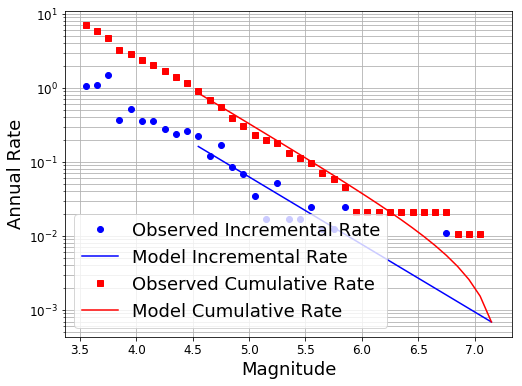

**Basic Gutenberg-Richter:**  *Do not use*
> `rate = 10 ** ( a_val - b_val * mag)`  

where  

    * ``a_val`` is the annual rate (y-intercept) at M=0
    * ``b_val`` is Gutenberg-Richter ``b`` value -- the decay rate
      of exponential distribution. It describes the relative size distribution
      of earthquakes: a higher ``b`` value indicates a relatively larger
      proportion of small events and vice versa.
    * ``mag`` is the magnitude used for the calcuation. e.g. mags = [4.5,4.6,4.7,4.8....]

**Offset between the observed and modelled MFD**

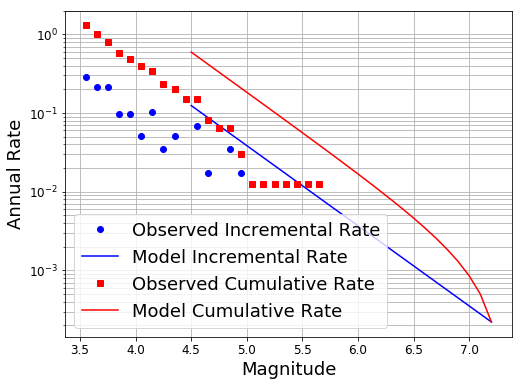    

**still a bit confused on this - also cumulative v. incremental**
**what about area normalised??**

# Notes on IncrementalMFD vs. Cumulative MFD

**For TruncatedGRMFD, EvenlyDiscretizedMFD, and YoungsCoppersmithMFD

**INCREMENTAL MFD: Called "Annual Rates" in OpenQuake
```python
# Get model annual occurrence rates
annual_rates = input_model.get_annual_occurrence_rates()
annual_rates = np.array([[val[0], val[1]] for val in annual_rates])
```

**CUMULATIVE MFD: Called "Cumulative Rates" in OpenQuake
```python
# Get cumulative rates
cumulative_rates = np.array([np.sum(annual_rates[iloc:, 1]) 
                             for iloc in range(0, len(annual_rates), 1)])
```

# Local Gridded Time Dependent Source

## Get coordinates for gridded sources

In [ ]:
source_model_weights = pd.read_excel(os.path.join(source_model_dir,'SeismicSourceModelParameters.xlsx'),engine='openpyxl')
source_model_weights.set_index(keys='Source Model',inplace=True)

In [ ]:
df_coordsGZ1 = pd.read_excel(os.path.join(source_model_dir,'GZgridded_source_coords_GZ1.xlsx'),engine='openpyxl')
display(df_coordsGZ1)
polygon_listGZ1 = []
shapely_polylistGZ1 = []
for index,row in df_coordsGZ1.iterrows():
    polygon_listGZ1.append(Point(row['longitude'],row['latitude']))
    shapely_polylistGZ1.append(shapely.geometry.Point(row['longitude'],row['latitude']))

shapely_polyGZ1 = shapely.geometry.Polygon(shapely_polylistGZ1)
gridded_polygonGZ1 = Polygon(polygon_listGZ1)
#print(local_polygon)

bounding_boxGZ1 = gridded_polygonGZ1.get_bbox()

In [ ]:
df_coordsGZ2 = pd.read_excel(os.path.join(source_model_dir,'GZgridded_source_coords_GZ2.xlsx'),engine='openpyxl')
display(df_coordsGZ2)
polygon_listGZ2 = []
shapely_polylistGZ2 = []
for index,row in df_coordsGZ2.iterrows():
    polygon_listGZ2.append(Point(row['longitude'],row['latitude']))
    shapely_polylistGZ2.append(shapely.geometry.Point(row['longitude'],row['latitude']))

shapely_polyGZ2 = shapely.geometry.Polygon(shapely_polylistGZ2)
gridded_polygonGZ2 = Polygon(polygon_listGZ2)
#print(local_polygon)

bounding_boxGZ2 = gridded_polygonGZ2.get_bbox()

In [ ]:
#creating polygons for entire catalogue area and get bounding box
gridded_polygon = Polygon([Point(137.150036, 0.513555), Point(137.150036, -19.513555), Point(170.165948, -19.513555), 
                           Point(170.165948, 0.513555)])
shapely_polygon = shapely.geometry.Polygon([shapely.geometry.Point(137.150036, 0.513555), 
                   shapely.geometry.Point(137.150036, -19.513555), 
                   shapely.geometry.Point(170.165948, -19.513555), 
                   shapely.geometry.Point(170.165948, 0.513555)])

bounding_box = gridded_polygon.get_bbox()

In [ ]:
recurrence_estimator = Weichert()

recurrence_config = {"magnitude_interval": 0.1, 
                     'reference_magnitude' : 0, # To get a-value for an incremental MFD rather than 10^a for cumulative # The remaining parameters are optional
                     'bvalue' : 1.0, # initial guess for b-value
                     'itstab': 1E-5, # the difference in b-value in order to reach convergence
                     'maxiter' : 1000} # max number of iterations

In [ ]:
# set up grid points
longitude_increment = 0.1
latitude_increment = 0.1
depth_min, depth_max, depth_increment = 0,50,50 # single depth bin

In [ ]:
# select catalogue events within the polygon
gridded_catalogue = CatalogueSelector(catalogue, create_copy=True).within_polygon(gridded_polygon,distance=None)
print(len(gridded_catalogue))

In [ ]:
# Grid limits should be set up as a dictionary
# [ min_long , max_long , spc_long ,
# min_lat max_lat , spc_lat ,
# min_depth , max_depth , spc_depth ]
grid_limits = Grid.make_from_catalogue(gridded_catalogue, 0.1,50)
print(grid_limits)

In [ ]:
# estimate recurrence parameters
recurrence_estimator = Weichert()

recurrence_config = {"magnitude_interval": 0.1, 
                     'reference_magnitude' : 0.0, # To get a-value for an incremental MFD rather than 10^a for cumulative # The remaining parameters are optional
                     'bvalue' : 1.0, # initial guess for b-value
                     'itstab': 1E-5, # the difference in b-value in order to reach convergence
                     'maxiter' : 1000} # max number of iterations

gridded_recurparam_dict = dict.fromkeys(['GZ1'])

for thisGZcat,label in zip([gridded_catalogue],['GZ1']):
    
    bval, sigma_b, aval, sigma_a = recurrence_estimator.calculate(thisGZcat,
                                                                  recurrence_config,
                                                                  completeness_table_a)

    print(label)
    print("a = %.3f (+/- %.3f),  b = %.3f (+/-%.3f)" % (aval, sigma_a, bval, sigma_b))
    
    gridded_recurparam_dict[label] = {'bval':bval,'sigma_b':sigma_b,'aval':aval,'sigma_a':sigma_a}

In [ ]:
print(gridded_recurparam_dict)

In [ ]:
# set smoothing kernel distances and weights
kernel_dists = [50.,75.,100.]
kernel_dists_weights = [0.2,0.6,0.2]
fullsmoothed_gridded_dict = dict.fromkeys(['GZ1'])
trimmed_smoothed_gridded_dict = dict.fromkeys(['GZ1'])

In [ ]:
if len(glob.glob(os.path.join(source_model_dir,'gridded_source','GZ*_smoothed_*'))) == 0:

    for grid_limits,grid_src_shapelypoly, gridded_catalogue,sourceID in zip([grid_limits],[shapely_polygon],[gridded_catalogue],['GZ1']):
        fullsmoothed_gridded_dict[sourceID] = dict.fromkeys(kernel_dists)
        trimmed_smoothed_gridded_dict[sourceID] = dict.fromkeys(kernel_dists)

        for kernel_dist in kernel_dists:

            bval = gridded_recurparam_dict[sourceID]['bval']

            smooth_seis = SmoothedSeismicity(grid_limits, 
                                         use_3d=False, #True: hypocentral distances; False: epicentral distances
                                         bvalue=bval)

            config = {'Length_Limit': 3., # number of kernel distances to extend grid beyond to prevent edge effects
                      'BandWidth': kernel_dist, 
                      'increment': True} 

            output_data = smooth_seis.run_analysis(gridded_catalogue, 
                                                   config, 
                                                   completeness_table_a, 
                                                   smoothing_kernel=IsotropicGaussian())



            smooth_seis.write_to_csv(os.path.join(source_model_dir,'gridded_source',sourceID+'_fullsmoothed_'+str(kernel_dist)+'_bval_'+str(round(bval,3)) + '.csv'))

            fullsmoothed_gridded_dict[sourceID][kernel_dist] = pd.read_csv(os.path.join(source_model_dir,'gridded_source',sourceID+'_fullsmoothed_'+str(kernel_dist)+'_bval_'+str(round(bval,3)) + '.csv'))

            rows_to_keep = []
            for index,row in fullsmoothed_gridded_dict[sourceID][kernel_dist].iterrows():
                tmp_point = shapely.geometry.Point(row['Longitude'],row['Latitude'])
                if grid_src_shapelypoly.contains(tmp_point):
                    rows_to_keep.append(index)
                    
            trimmed_smoothed_gridded_dict[sourceID][kernel_dist] = fullsmoothed_gridded_dict[sourceID][kernel_dist][fullsmoothed_gridded_dict[sourceID][kernel_dist].index.isin(rows_to_keep)]
            
            
else:
    for grid_limits,grid_src_poly, gridded_catalogue,sourceID in zip([grid_limits],[gridded_polygon],[gridded_catalogue],['GZ1']):
        for kernel_dist in kernel_dists:
            fullsmoothed_gridded_dict[sourceID][kernel_dist] = pd.read_csv(os.path.join(source_model_dir,'gridded_source',sourceID+'_fullsmoothed_'+str(kernel_dist)+'_bval_'+str(round(bval,3)) + '.csv'))
            
            rows_to_keep = []
            for index,row in fullsmoothed_gridded_dict[sourceID][kernel_dist].iterrows():
                tmp_point = shapely.geometry.Point(row['Longitude'],row['Latitude'])
                print(type(grid_src_shapelypoly))
                if grid_src_shapelypoly.contains(tmp_point):
                    rows_to_keep.append(index)
                    
            trimmed_smoothed_gridded_dict[sourceID][kernel_dist] = fullsmoothed_gridded_dict[sourceID][kernel_dist][fullsmoothed_gridded_dict[sourceID][kernel_dist].index.isin(rows_to_keep)]

In [ ]:
display(trimmed_smoothed_gridded_dict['GZ1'][kernel_dist])
print(max(trimmed_smoothed_gridded_dict['GZ1'][kernel_dist]['Observed Count']))

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[15,15])
max_rate = max(trimmed_smoothed_gridded_dict['GZ1'][kernel_dist]['Longitude'])
#max_rate = max(max_rate)
for gridded_src in ['GZ1']:
    tmpdf = trimmed_smoothed_gridded_dict[gridded_src][kernel_dist]
    plothandle1 = ax.scatter(trimmed_smoothed_gridded_dict[gridded_src][kernel_dist]['Longitude'], trimmed_smoothed_gridded_dict[gridded_src][kernel_dist]['Latitude'], c=trimmed_smoothed_gridded_dict[gridded_src][kernel_dist]['Smoothed Rate'],s=70)
    
#ax.scatter(sLon,sLat,c='white',marker='X')
#ax.plot(df_coordsGZ1['longitude'],df_coordsGZ1['latitude'],c='white')
cbar = plt.colorbar(plothandle1)